In [32]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cse-251-b-2025/train.npz
/kaggle/input/cse-251-b-2025/test_input.npz


In [122]:
# download the dataset to your folder or use it on kaggle notebook directly

# train_file = np.load('/your_folder/cse-251-b-2025/train.npz')
train_file = np.load('/kaggle/input/cse-251-b-2025/train.npz')

train_data = train_file['data']
print("train_data's shape", train_data.shape)
# test_file = np.load('/your_folder/test_input.npz')
test_file = np.load('/kaggle/input/cse-251-b-2025/test_input.npz')

test_data = test_file['data']
print("test_data's shape", test_data.shape)

train_data's shape (10000, 50, 110, 6)
test_data's shape (2100, 50, 50, 6)


In [123]:
import numpy as np

def ego_centric_normalize(data):
    """
    Args:
        data: np.ndarray of shape (N, 50, 110, 6)
    
    Returns:
        normalized_data: np.ndarray of same shape, centered so ego starts at (0, 0)
    """
    # Extract ego agent's position at t=0
    ego_start_pos = data[:, 0, 0, :2]  # shape (N, 2)
    
    # Subtract ego position from all agent positions across all time steps
    centered_positions = data[..., :2] - ego_start_pos[:, None, None, :]  # shape (N, 50, 110, 2)
    
    # Copy rest of data as-is
    normalized_data = np.copy(data)
    normalized_data[..., :2] = centered_positions  # update x, y
    
    return ego_start_pos, normalized_data


In [124]:
ego_train_start_pos, train_data = ego_centric_normalize(train_data)
ego_start_pos, test_data = ego_centric_normalize(test_data)

In [125]:
train_data = train_data[..., :5]
test_data = test_data[..., :5]
print("train_data's shape", train_data.shape)
print("test_data's shape", test_data.shape)

train_data's shape (10000, 50, 110, 5)
test_data's shape (2100, 50, 50, 5)


In [126]:
# Split x and y for train data.

train_amt = 10000

# for now, let us only care about argo vehicle information
train_x, train_y = train_data[:train_amt, :, :50, :], train_data[:train_amt, 0, 50:, :2]

print(train_x.shape, train_y.shape)

(10000, 50, 50, 5) (10000, 60, 2)


In [127]:
val_x, val_y = train_data[train_amt:, :, :50, :], train_data[train_amt:, 0, 50:, :2]

print(val_x.shape, val_y.shape)

(0, 50, 50, 5) (0, 60, 2)


In [128]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from torch.optim.lr_scheduler import CosineAnnealingLR

In [10]:
class MLP(nn.Module):
    def __init__(self, input_features, output_features):
        super(MLP, self).__init__()
        
        # Define the layers
        self.flatten = nn.Flatten()
        self.mlp = nn.Sequential(
            nn.Linear(input_features, 1024),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(256, output_features)
        )
    
    def forward(self, x):
        x = self.flatten(x)
        x = self.mlp(x)
        return x.view(x.size(0), 60, 2)

In [11]:
input_features = 50 * 50 * 5  # = 5000
output_features = 60 * 2

mlp_model = MLP(input_features, output_features)

# Define loss function and optimizer
criterion = nn.MSELoss()  # For regression task

optimizer = optim.AdamW(mlp_model.parameters(), lr=0.0001, weight_decay=1e-4)

scheduler = CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-5)

In [12]:
import torch
import torch.nn as nn

class SimpleTrajectoryPredictionCNN(nn.Module):
    def __init__(self, input_channels, num_agents=50, seq_len=50, hidden_size=64, dropout=0.3):
        super(SimpleTrajectoryPredictionCNN, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(num_agents, hidden_size, kernel_size=(5, 1), stride=(2, 1), padding=(2, 0)),
            nn.ReLU(),
            nn.Conv2d(hidden_size, hidden_size, kernel_size=(5, 1), stride=(2, 1), padding=(2, 0)),
            nn.ReLU()
        )

        self.flatten = nn.Flatten()  # shape: (B, hidden_size * new_seq_len * input_channels)

        self.fc = nn.Sequential(
            nn.Linear(hidden_size * ((seq_len // 4) + 1) * input_channels, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, 2 * 60)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x.view(x.size(0), 60, 2)  # (B, 60, 2)


In [13]:
simple_cnn_model = SimpleTrajectoryPredictionCNN(train_data.shape[3])

# Define loss function and optimizer
simple_cnn_criterion = nn.MSELoss()  # For regression task

simple_cnn_optimizer = optim.AdamW(simple_cnn_model.parameters(), lr=0.0001, weight_decay=1e-4)

simple_cnn_scheduler = CosineAnnealingLR(simple_cnn_optimizer, T_max=200, eta_min=1e-6)

In [14]:
import torch
import torch.nn as nn

class TrajectoryPredictionCNN(nn.Module):
    def __init__(self, input_channels, num_agents=50, seq_len=50, hidden_size=128, dropout=0.3):
        super(TrajectoryPredictionCNN, self).__init__()
        
        # Stage 1: Compress seq_len 50 → 25
        self.conv1 = nn.Conv2d(
            in_channels=num_agents, 
            out_channels=hidden_size, 
            kernel_size=(5, 1),      
            stride=(2, 1),
            padding=(2,0)
        )
        self.bn_conv1 = nn.BatchNorm2d(hidden_size)
        
        # Stage 2: Compress seq_len 25 → 12
        self.conv2_downsample = nn.Conv2d(
            in_channels=hidden_size, 
            out_channels=hidden_size, 
            kernel_size=(5, 1), 
            stride=(2, 1),
            padding=(1,0)
        )
        self.bn_conv2_ds = nn.BatchNorm2d(hidden_size)
        
        self.conv3_downsample = nn.Conv2d(
            in_channels=hidden_size, 
            out_channels=hidden_size, 
            kernel_size=(5, 1),     # Reduce from 12 → 6
            stride=(2, 1),          
            padding=(2,0)
        )
        self.bn_conv3_ds = nn.BatchNorm2d(hidden_size)

        self.conv4_downsample = nn.Conv2d(
            in_channels=hidden_size,
            out_channels=hidden_size,
            kernel_size=(6, 1),
            stride=(1, 1)
        )
        self.bn_conv4_ds = nn.BatchNorm2d(hidden_size)

        self.conv2 = nn.Conv2d(
            in_channels=hidden_size, 
            out_channels=hidden_size, 
            kernel_size=(1, 1)       
        )
        self.bn_conv2 = nn.BatchNorm2d(hidden_size)
        
        self.conv_to_fc = nn.Linear(hidden_size * input_channels, hidden_size)
        self.bn_conv_to_fc = nn.BatchNorm1d(hidden_size)
        
        self.fc1 = nn.Linear(hidden_size, 2 * hidden_size)
        self.bn1 = nn.BatchNorm1d(2 * hidden_size)
        
        self.fc2 = nn.Linear(2 * hidden_size, hidden_size)
        self.bn2 = nn.BatchNorm1d(hidden_size)
        
        self.fc3 = nn.Linear(hidden_size, 2 * 60)
        self.dropout = nn.Dropout(dropout)
        
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Input: (batch_size, num_agents, seq_len=50, input_channels)
        
        # Stage 1: seq_len 50 → 25
        x = self.conv1(x)           # (B, hidden_size, 25, input_channels)
        x = self.bn_conv1(x)
        x = torch.relu(x)
        
        # Stage 2: seq_len 25 → 12
        x = self.conv2_downsample(x) # (B, hidden_size, 12, input_channels)
        x = self.bn_conv2_ds(x)
        x = torch.relu(x)
        
        x = self.conv3_downsample(x)  # (B, hidden_size, 6, input_channels)
        x = self.bn_conv3_ds(x)
        x = torch.relu(x)
        
        # Stage 4: seq_len 6 → 1
        x = self.conv4_downsample(x)  # (B, hidden_size, 1, input_channels)
        residual = x
        x = self.bn_conv4_ds(x)
        x = torch.relu(x)
        
        x = self.conv2(x)           # (B, hidden_size, 1, input_channels)
        x = self.bn_conv2(x)
        x += residual
        x = torch.relu(x)

        x = x.squeeze(2)            # (B, hidden_size, input_channels)
        x = x.reshape(x.size(0), -1) # (B, hidden_size * input_channels)
        
        # Continue with original FC layers
        x = self.conv_to_fc(x)
        residual = x
        x = self.bn_conv_to_fc(x)
        x = torch.relu(x)
        x = self.dropout(x)
        
        out = self.fc1(x)
        out = self.bn1(out)
        out = torch.relu(out)
        out = self.dropout(out)
        
        out = self.fc2(out)
        out = self.bn2(out)
        out += residual
        out = torch.relu(out)
        out = self.fc3(out)
        
        return out.view(out.size(0), 60, 2)  # (B, 60, 2)

In [15]:
# Create the model
deep_cnn_model = TrajectoryPredictionCNN(train_data.shape[3])

# Define loss function and optimizer
deep_cnn_criterion = nn.MSELoss()  # For regression task

deep_cnn_optimizer = optim.AdamW(deep_cnn_model.parameters(), lr=0.0005, weight_decay=1e-4)

deep_cnn_scheduler = CosineAnnealingLR(deep_cnn_optimizer, T_max=450, eta_min=1e-6)

In [16]:
from torch.utils.data import DataLoader, TensorDataset
import torch
from tqdm import tqdm

def train_model(model, optimizer, criterion, scheduler, x_train, y_train, x_val, y_val,
                batch_size=64, epochs=30, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
    
    # Move model to device
    model = model.to(device)

    # Convert numpy arrays to PyTorch tensors and move them to the device
    X_train_tensor = torch.FloatTensor(x_train)
    y_train_tensor = torch.FloatTensor(y_train)
    X_val_tensor = torch.FloatTensor(x_val)
    y_val_tensor = torch.FloatTensor(y_val)
    
    # Create datasets and dataloaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Training loop
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        
        for batch_X, batch_y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(batch_X)
            assert outputs.shape == batch_y.shape

            # Compute loss
            loss = criterion(outputs, batch_y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            running_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                
                outputs = model(batch_X)
                assert outputs.shape == batch_y.shape
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()
        
        scheduler.step()

        print(f'Epoch {epoch+1}, Train Loss: {running_loss/len(train_loader):.4f}, Validation Loss: {val_loss/(1 if len(val_loader) == 0 else 0):.4f}')
    
    return model


In [17]:
mlp_model = train_model(mlp_model, optimizer, criterion, scheduler, train_x, train_y, val_x, val_y, 64, 100)

Epoch 1/100: 100%|██████████| 157/157 [00:03<00:00, 46.63it/s]


Epoch 1, Train Loss: 1786.3711, Validation Loss: 0.0000


Epoch 2/100: 100%|██████████| 157/157 [00:01<00:00, 103.35it/s]


Epoch 2, Train Loss: 1575.9810, Validation Loss: 0.0000


Epoch 3/100: 100%|██████████| 157/157 [00:01<00:00, 102.97it/s]


Epoch 3, Train Loss: 1566.7064, Validation Loss: 0.0000


Epoch 4/100: 100%|██████████| 157/157 [00:01<00:00, 102.98it/s]


Epoch 4, Train Loss: 1565.5882, Validation Loss: 0.0000


Epoch 5/100: 100%|██████████| 157/157 [00:01<00:00, 104.31it/s]


Epoch 5, Train Loss: 1566.2695, Validation Loss: 0.0000


Epoch 6/100: 100%|██████████| 157/157 [00:01<00:00, 103.81it/s]


Epoch 6, Train Loss: 1564.9210, Validation Loss: 0.0000


Epoch 7/100: 100%|██████████| 157/157 [00:01<00:00, 103.39it/s]


Epoch 7, Train Loss: 1562.2297, Validation Loss: 0.0000


Epoch 8/100: 100%|██████████| 157/157 [00:01<00:00, 102.99it/s]


Epoch 8, Train Loss: 1677.9440, Validation Loss: 0.0000


Epoch 9/100: 100%|██████████| 157/157 [00:01<00:00, 102.52it/s]


Epoch 9, Train Loss: 1547.8025, Validation Loss: 0.0000


Epoch 10/100: 100%|██████████| 157/157 [00:01<00:00, 103.98it/s]


Epoch 10, Train Loss: 1551.9884, Validation Loss: 0.0000


Epoch 11/100: 100%|██████████| 157/157 [00:01<00:00, 102.93it/s]


Epoch 11, Train Loss: 1535.8001, Validation Loss: 0.0000


Epoch 12/100: 100%|██████████| 157/157 [00:01<00:00, 103.87it/s]


Epoch 12, Train Loss: 1517.0287, Validation Loss: 0.0000


Epoch 13/100: 100%|██████████| 157/157 [00:01<00:00, 102.65it/s]


Epoch 13, Train Loss: 1468.0194, Validation Loss: 0.0000


Epoch 14/100: 100%|██████████| 157/157 [00:01<00:00, 102.38it/s]


Epoch 14, Train Loss: 1419.9634, Validation Loss: 0.0000


Epoch 15/100: 100%|██████████| 157/157 [00:01<00:00, 104.22it/s]


Epoch 15, Train Loss: 1366.9994, Validation Loss: 0.0000


Epoch 16/100: 100%|██████████| 157/157 [00:01<00:00, 103.70it/s]


Epoch 16, Train Loss: 1299.4295, Validation Loss: 0.0000


Epoch 17/100: 100%|██████████| 157/157 [00:01<00:00, 102.93it/s]


Epoch 17, Train Loss: 1231.2856, Validation Loss: 0.0000


Epoch 18/100: 100%|██████████| 157/157 [00:01<00:00, 102.11it/s]


Epoch 18, Train Loss: 1147.9605, Validation Loss: 0.0000


Epoch 19/100: 100%|██████████| 157/157 [00:01<00:00, 101.81it/s]


Epoch 19, Train Loss: 1039.3221, Validation Loss: 0.0000


Epoch 20/100: 100%|██████████| 157/157 [00:01<00:00, 102.89it/s]


Epoch 20, Train Loss: 982.0995, Validation Loss: 0.0000


Epoch 21/100: 100%|██████████| 157/157 [00:01<00:00, 104.01it/s]


Epoch 21, Train Loss: 977.2389, Validation Loss: 0.0000


Epoch 22/100: 100%|██████████| 157/157 [00:01<00:00, 103.89it/s]


Epoch 22, Train Loss: 906.0392, Validation Loss: 0.0000


Epoch 23/100: 100%|██████████| 157/157 [00:01<00:00, 101.36it/s]


Epoch 23, Train Loss: 884.1657, Validation Loss: 0.0000


Epoch 24/100: 100%|██████████| 157/157 [00:01<00:00, 103.99it/s]


Epoch 24, Train Loss: 819.3329, Validation Loss: 0.0000


Epoch 25/100: 100%|██████████| 157/157 [00:01<00:00, 104.64it/s]


Epoch 25, Train Loss: 774.2687, Validation Loss: 0.0000


Epoch 26/100: 100%|██████████| 157/157 [00:01<00:00, 103.79it/s]


Epoch 26, Train Loss: 671.0077, Validation Loss: 0.0000


Epoch 27/100: 100%|██████████| 157/157 [00:01<00:00, 101.87it/s]


Epoch 27, Train Loss: 637.1536, Validation Loss: 0.0000


Epoch 28/100: 100%|██████████| 157/157 [00:01<00:00, 101.39it/s]


Epoch 28, Train Loss: 559.6365, Validation Loss: 0.0000


Epoch 29/100: 100%|██████████| 157/157 [00:01<00:00, 102.96it/s]


Epoch 29, Train Loss: 495.8886, Validation Loss: 0.0000


Epoch 30/100: 100%|██████████| 157/157 [00:01<00:00, 102.81it/s]


Epoch 30, Train Loss: 459.2868, Validation Loss: 0.0000


Epoch 31/100: 100%|██████████| 157/157 [00:01<00:00, 104.49it/s]


Epoch 31, Train Loss: 434.5953, Validation Loss: 0.0000


Epoch 32/100: 100%|██████████| 157/157 [00:01<00:00, 103.73it/s]


Epoch 32, Train Loss: 402.7527, Validation Loss: 0.0000


Epoch 33/100: 100%|██████████| 157/157 [00:01<00:00, 102.64it/s]


Epoch 33, Train Loss: 419.2227, Validation Loss: 0.0000


Epoch 34/100: 100%|██████████| 157/157 [00:01<00:00, 104.05it/s]


Epoch 34, Train Loss: 375.3687, Validation Loss: 0.0000


Epoch 35/100: 100%|██████████| 157/157 [00:01<00:00, 104.51it/s]


Epoch 35, Train Loss: 369.8948, Validation Loss: 0.0000


Epoch 36/100: 100%|██████████| 157/157 [00:01<00:00, 103.82it/s]


Epoch 36, Train Loss: 337.4520, Validation Loss: 0.0000


Epoch 37/100: 100%|██████████| 157/157 [00:01<00:00, 103.40it/s]


Epoch 37, Train Loss: 334.0593, Validation Loss: 0.0000


Epoch 38/100: 100%|██████████| 157/157 [00:01<00:00, 103.42it/s]


Epoch 38, Train Loss: 327.3346, Validation Loss: 0.0000


Epoch 39/100: 100%|██████████| 157/157 [00:01<00:00, 101.58it/s]


Epoch 39, Train Loss: 280.0951, Validation Loss: 0.0000


Epoch 40/100: 100%|██████████| 157/157 [00:01<00:00, 102.03it/s]


Epoch 40, Train Loss: 288.9966, Validation Loss: 0.0000


Epoch 41/100: 100%|██████████| 157/157 [00:01<00:00, 104.50it/s]


Epoch 41, Train Loss: 273.1107, Validation Loss: 0.0000


Epoch 42/100: 100%|██████████| 157/157 [00:01<00:00, 101.67it/s]


Epoch 42, Train Loss: 250.4479, Validation Loss: 0.0000


Epoch 43/100: 100%|██████████| 157/157 [00:01<00:00, 102.70it/s]


Epoch 43, Train Loss: 249.4826, Validation Loss: 0.0000


Epoch 44/100: 100%|██████████| 157/157 [00:01<00:00, 102.90it/s]


Epoch 44, Train Loss: 239.2621, Validation Loss: 0.0000


Epoch 45/100: 100%|██████████| 157/157 [00:01<00:00, 104.23it/s]


Epoch 45, Train Loss: 232.5970, Validation Loss: 0.0000


Epoch 46/100: 100%|██████████| 157/157 [00:01<00:00, 103.33it/s]


Epoch 46, Train Loss: 232.0979, Validation Loss: 0.0000


Epoch 47/100: 100%|██████████| 157/157 [00:01<00:00, 101.03it/s]


Epoch 47, Train Loss: 221.5618, Validation Loss: 0.0000


Epoch 48/100: 100%|██████████| 157/157 [00:01<00:00, 103.31it/s]


Epoch 48, Train Loss: 211.3272, Validation Loss: 0.0000


Epoch 49/100: 100%|██████████| 157/157 [00:01<00:00, 102.76it/s]


Epoch 49, Train Loss: 215.3918, Validation Loss: 0.0000


Epoch 50/100: 100%|██████████| 157/157 [00:01<00:00, 103.69it/s]


Epoch 50, Train Loss: 203.5973, Validation Loss: 0.0000


Epoch 51/100: 100%|██████████| 157/157 [00:01<00:00, 104.11it/s]


Epoch 51, Train Loss: 192.3756, Validation Loss: 0.0000


Epoch 52/100: 100%|██████████| 157/157 [00:01<00:00, 102.00it/s]


Epoch 52, Train Loss: 194.1194, Validation Loss: 0.0000


Epoch 53/100: 100%|██████████| 157/157 [00:01<00:00, 101.86it/s]


Epoch 53, Train Loss: 185.9884, Validation Loss: 0.0000


Epoch 54/100: 100%|██████████| 157/157 [00:01<00:00, 104.18it/s]


Epoch 54, Train Loss: 178.4258, Validation Loss: 0.0000


Epoch 55/100: 100%|██████████| 157/157 [00:01<00:00, 102.90it/s]


Epoch 55, Train Loss: 174.3158, Validation Loss: 0.0000


Epoch 56/100: 100%|██████████| 157/157 [00:01<00:00, 103.14it/s]


Epoch 56, Train Loss: 171.9222, Validation Loss: 0.0000


Epoch 57/100: 100%|██████████| 157/157 [00:01<00:00, 101.93it/s]


Epoch 57, Train Loss: 170.4177, Validation Loss: 0.0000


Epoch 58/100: 100%|██████████| 157/157 [00:01<00:00, 104.13it/s]


Epoch 58, Train Loss: 159.5164, Validation Loss: 0.0000


Epoch 59/100: 100%|██████████| 157/157 [00:01<00:00, 103.83it/s]


Epoch 59, Train Loss: 152.2983, Validation Loss: 0.0000


Epoch 60/100: 100%|██████████| 157/157 [00:01<00:00, 99.73it/s] 


Epoch 60, Train Loss: 154.1432, Validation Loss: 0.0000


Epoch 61/100: 100%|██████████| 157/157 [00:01<00:00, 103.45it/s]


Epoch 61, Train Loss: 151.1859, Validation Loss: 0.0000


Epoch 62/100: 100%|██████████| 157/157 [00:01<00:00, 102.68it/s]


Epoch 62, Train Loss: 151.9404, Validation Loss: 0.0000


Epoch 63/100: 100%|██████████| 157/157 [00:01<00:00, 102.27it/s]


Epoch 63, Train Loss: 134.7994, Validation Loss: 0.0000


Epoch 64/100: 100%|██████████| 157/157 [00:01<00:00, 103.91it/s]


Epoch 64, Train Loss: 139.9143, Validation Loss: 0.0000


Epoch 65/100: 100%|██████████| 157/157 [00:01<00:00, 104.69it/s]


Epoch 65, Train Loss: 131.9126, Validation Loss: 0.0000


Epoch 66/100: 100%|██████████| 157/157 [00:01<00:00, 103.33it/s]


Epoch 66, Train Loss: 126.4125, Validation Loss: 0.0000


Epoch 67/100: 100%|██████████| 157/157 [00:01<00:00, 102.25it/s]


Epoch 67, Train Loss: 124.8633, Validation Loss: 0.0000


Epoch 68/100: 100%|██████████| 157/157 [00:01<00:00, 102.31it/s]


Epoch 68, Train Loss: 123.6526, Validation Loss: 0.0000


Epoch 69/100: 100%|██████████| 157/157 [00:01<00:00, 103.64it/s]


Epoch 69, Train Loss: 121.2326, Validation Loss: 0.0000


Epoch 70/100: 100%|██████████| 157/157 [00:01<00:00, 103.78it/s]


Epoch 70, Train Loss: 118.5071, Validation Loss: 0.0000


Epoch 71/100: 100%|██████████| 157/157 [00:01<00:00, 103.20it/s]


Epoch 71, Train Loss: 119.2603, Validation Loss: 0.0000


Epoch 72/100: 100%|██████████| 157/157 [00:01<00:00, 103.43it/s]


Epoch 72, Train Loss: 109.6228, Validation Loss: 0.0000


Epoch 73/100: 100%|██████████| 157/157 [00:01<00:00, 103.43it/s]


Epoch 73, Train Loss: 106.8777, Validation Loss: 0.0000


Epoch 74/100: 100%|██████████| 157/157 [00:01<00:00, 104.72it/s]


Epoch 74, Train Loss: 104.3021, Validation Loss: 0.0000


Epoch 75/100: 100%|██████████| 157/157 [00:01<00:00, 103.90it/s]


Epoch 75, Train Loss: 105.4999, Validation Loss: 0.0000


Epoch 76/100: 100%|██████████| 157/157 [00:01<00:00, 103.49it/s]


Epoch 76, Train Loss: 103.5604, Validation Loss: 0.0000


Epoch 77/100: 100%|██████████| 157/157 [00:01<00:00, 103.07it/s]


Epoch 77, Train Loss: 103.2400, Validation Loss: 0.0000


Epoch 78/100: 100%|██████████| 157/157 [00:01<00:00, 103.51it/s]


Epoch 78, Train Loss: 97.8997, Validation Loss: 0.0000


Epoch 79/100: 100%|██████████| 157/157 [00:01<00:00, 103.50it/s]


Epoch 79, Train Loss: 95.3001, Validation Loss: 0.0000


Epoch 80/100: 100%|██████████| 157/157 [00:01<00:00, 104.20it/s]


Epoch 80, Train Loss: 102.3248, Validation Loss: 0.0000


Epoch 81/100: 100%|██████████| 157/157 [00:01<00:00, 99.52it/s] 


Epoch 81, Train Loss: 92.8721, Validation Loss: 0.0000


Epoch 82/100: 100%|██████████| 157/157 [00:01<00:00, 102.48it/s]


Epoch 82, Train Loss: 91.8479, Validation Loss: 0.0000


Epoch 83/100: 100%|██████████| 157/157 [00:01<00:00, 103.18it/s]


Epoch 83, Train Loss: 91.7544, Validation Loss: 0.0000


Epoch 84/100: 100%|██████████| 157/157 [00:01<00:00, 103.70it/s]


Epoch 84, Train Loss: 91.7184, Validation Loss: 0.0000


Epoch 85/100: 100%|██████████| 157/157 [00:01<00:00, 103.17it/s]


Epoch 85, Train Loss: 87.8122, Validation Loss: 0.0000


Epoch 86/100: 100%|██████████| 157/157 [00:01<00:00, 101.56it/s]


Epoch 86, Train Loss: 91.1019, Validation Loss: 0.0000


Epoch 87/100: 100%|██████████| 157/157 [00:01<00:00, 102.37it/s]


Epoch 87, Train Loss: 85.0912, Validation Loss: 0.0000


Epoch 88/100: 100%|██████████| 157/157 [00:01<00:00, 102.39it/s]


Epoch 88, Train Loss: 83.9821, Validation Loss: 0.0000


Epoch 89/100: 100%|██████████| 157/157 [00:01<00:00, 104.81it/s]


Epoch 89, Train Loss: 79.0405, Validation Loss: 0.0000


Epoch 90/100: 100%|██████████| 157/157 [00:01<00:00, 103.03it/s]


Epoch 90, Train Loss: 85.8270, Validation Loss: 0.0000


Epoch 91/100: 100%|██████████| 157/157 [00:01<00:00, 103.11it/s]


Epoch 91, Train Loss: 79.2747, Validation Loss: 0.0000


Epoch 92/100: 100%|██████████| 157/157 [00:01<00:00, 101.84it/s]


Epoch 92, Train Loss: 80.0913, Validation Loss: 0.0000


Epoch 93/100: 100%|██████████| 157/157 [00:01<00:00, 103.76it/s]


Epoch 93, Train Loss: 78.5745, Validation Loss: 0.0000


Epoch 94/100: 100%|██████████| 157/157 [00:01<00:00, 103.91it/s]


Epoch 94, Train Loss: 79.4101, Validation Loss: 0.0000


Epoch 95/100: 100%|██████████| 157/157 [00:01<00:00, 104.28it/s]


Epoch 95, Train Loss: 78.4325, Validation Loss: 0.0000


Epoch 96/100: 100%|██████████| 157/157 [00:01<00:00, 103.22it/s]


Epoch 96, Train Loss: 78.0209, Validation Loss: 0.0000


Epoch 97/100: 100%|██████████| 157/157 [00:01<00:00, 103.36it/s]


Epoch 97, Train Loss: 75.9711, Validation Loss: 0.0000


Epoch 98/100: 100%|██████████| 157/157 [00:01<00:00, 103.99it/s]


Epoch 98, Train Loss: 77.8354, Validation Loss: 0.0000


Epoch 99/100: 100%|██████████| 157/157 [00:01<00:00, 101.84it/s]


Epoch 99, Train Loss: 74.3234, Validation Loss: 0.0000


Epoch 100/100: 100%|██████████| 157/157 [00:01<00:00, 103.39it/s]

Epoch 100, Train Loss: 74.6045, Validation Loss: 0.0000


In [18]:
simple_cnn_model = train_model(simple_cnn_model, simple_cnn_optimizer, simple_cnn_criterion, simple_cnn_scheduler, train_x, train_y, val_x, val_y, 64, 100)

Epoch 1/100: 100%|██████████| 157/157 [00:02<00:00, 73.19it/s] 


Epoch 1, Train Loss: 1614.6539, Validation Loss: 0.0000


Epoch 2/100: 100%|██████████| 157/157 [00:00<00:00, 197.05it/s]


Epoch 2, Train Loss: 1563.0197, Validation Loss: 0.0000


Epoch 3/100: 100%|██████████| 157/157 [00:00<00:00, 207.30it/s]


Epoch 3, Train Loss: 1561.6868, Validation Loss: 0.0000


Epoch 4/100: 100%|██████████| 157/157 [00:00<00:00, 208.44it/s]


Epoch 4, Train Loss: 1560.8332, Validation Loss: 0.0000


Epoch 5/100: 100%|██████████| 157/157 [00:00<00:00, 203.68it/s]


Epoch 5, Train Loss: 1565.6127, Validation Loss: 0.0000


Epoch 6/100: 100%|██████████| 157/157 [00:00<00:00, 200.47it/s]


Epoch 6, Train Loss: 1561.7511, Validation Loss: 0.0000


Epoch 7/100: 100%|██████████| 157/157 [00:00<00:00, 204.35it/s]


Epoch 7, Train Loss: 1562.2810, Validation Loss: 0.0000


Epoch 8/100: 100%|██████████| 157/157 [00:00<00:00, 194.12it/s]


Epoch 8, Train Loss: 1563.2954, Validation Loss: 0.0000


Epoch 9/100: 100%|██████████| 157/157 [00:00<00:00, 194.90it/s]


Epoch 9, Train Loss: 1562.4940, Validation Loss: 0.0000


Epoch 10/100: 100%|██████████| 157/157 [00:00<00:00, 197.66it/s]


Epoch 10, Train Loss: 1563.3920, Validation Loss: 0.0000


Epoch 11/100: 100%|██████████| 157/157 [00:00<00:00, 195.58it/s]


Epoch 11, Train Loss: 1566.8824, Validation Loss: 0.0000


Epoch 12/100: 100%|██████████| 157/157 [00:00<00:00, 194.00it/s]


Epoch 12, Train Loss: 1562.9508, Validation Loss: 0.0000


Epoch 13/100: 100%|██████████| 157/157 [00:00<00:00, 202.73it/s]


Epoch 13, Train Loss: 1563.0600, Validation Loss: 0.0000


Epoch 14/100: 100%|██████████| 157/157 [00:00<00:00, 205.03it/s]


Epoch 14, Train Loss: 1560.6835, Validation Loss: 0.0000


Epoch 15/100: 100%|██████████| 157/157 [00:00<00:00, 203.74it/s]


Epoch 15, Train Loss: 1565.7563, Validation Loss: 0.0000


Epoch 16/100: 100%|██████████| 157/157 [00:00<00:00, 205.77it/s]


Epoch 16, Train Loss: 1560.4010, Validation Loss: 0.0000


Epoch 17/100: 100%|██████████| 157/157 [00:00<00:00, 204.43it/s]


Epoch 17, Train Loss: 1561.4824, Validation Loss: 0.0000


Epoch 18/100: 100%|██████████| 157/157 [00:00<00:00, 201.56it/s]


Epoch 18, Train Loss: 1562.9383, Validation Loss: 0.0000


Epoch 19/100: 100%|██████████| 157/157 [00:00<00:00, 198.82it/s]


Epoch 19, Train Loss: 1563.9649, Validation Loss: 0.0000


Epoch 20/100: 100%|██████████| 157/157 [00:00<00:00, 196.74it/s]


Epoch 20, Train Loss: 1559.7292, Validation Loss: 0.0000


Epoch 21/100: 100%|██████████| 157/157 [00:00<00:00, 197.32it/s]


Epoch 21, Train Loss: 1562.5697, Validation Loss: 0.0000


Epoch 22/100: 100%|██████████| 157/157 [00:00<00:00, 205.60it/s]


Epoch 22, Train Loss: 1559.5672, Validation Loss: 0.0000


Epoch 23/100: 100%|██████████| 157/157 [00:00<00:00, 208.45it/s]


Epoch 23, Train Loss: 1559.9721, Validation Loss: 0.0000


Epoch 24/100: 100%|██████████| 157/157 [00:00<00:00, 207.10it/s]


Epoch 24, Train Loss: 1559.8863, Validation Loss: 0.0000


Epoch 25/100: 100%|██████████| 157/157 [00:00<00:00, 207.32it/s]


Epoch 25, Train Loss: 1560.7762, Validation Loss: 0.0000


Epoch 26/100: 100%|██████████| 157/157 [00:00<00:00, 206.51it/s]


Epoch 26, Train Loss: 1562.4413, Validation Loss: 0.0000


Epoch 27/100: 100%|██████████| 157/157 [00:00<00:00, 207.21it/s]


Epoch 27, Train Loss: 1561.6875, Validation Loss: 0.0000


Epoch 28/100: 100%|██████████| 157/157 [00:00<00:00, 200.18it/s]


Epoch 28, Train Loss: 1559.1666, Validation Loss: 0.0000


Epoch 29/100: 100%|██████████| 157/157 [00:00<00:00, 199.58it/s]


Epoch 29, Train Loss: 1563.6631, Validation Loss: 0.0000


Epoch 30/100: 100%|██████████| 157/157 [00:00<00:00, 200.92it/s]


Epoch 30, Train Loss: 1562.0618, Validation Loss: 0.0000


Epoch 31/100: 100%|██████████| 157/157 [00:00<00:00, 201.50it/s]


Epoch 31, Train Loss: 1559.2762, Validation Loss: 0.0000


Epoch 32/100: 100%|██████████| 157/157 [00:00<00:00, 201.99it/s]


Epoch 32, Train Loss: 1561.1512, Validation Loss: 0.0000


Epoch 33/100: 100%|██████████| 157/157 [00:00<00:00, 201.96it/s]


Epoch 33, Train Loss: 1563.0674, Validation Loss: 0.0000


Epoch 34/100: 100%|██████████| 157/157 [00:00<00:00, 200.21it/s]


Epoch 34, Train Loss: 1565.5190, Validation Loss: 0.0000


Epoch 35/100: 100%|██████████| 157/157 [00:00<00:00, 201.53it/s]


Epoch 35, Train Loss: 1560.2979, Validation Loss: 0.0000


Epoch 36/100: 100%|██████████| 157/157 [00:00<00:00, 203.03it/s]


Epoch 36, Train Loss: 1561.4476, Validation Loss: 0.0000


Epoch 37/100: 100%|██████████| 157/157 [00:00<00:00, 200.79it/s]


Epoch 37, Train Loss: 1561.4440, Validation Loss: 0.0000


Epoch 38/100: 100%|██████████| 157/157 [00:00<00:00, 197.96it/s]


Epoch 38, Train Loss: 1560.8177, Validation Loss: 0.0000


Epoch 39/100: 100%|██████████| 157/157 [00:00<00:00, 198.64it/s]


Epoch 39, Train Loss: 1558.5257, Validation Loss: 0.0000


Epoch 40/100: 100%|██████████| 157/157 [00:00<00:00, 206.18it/s]


Epoch 40, Train Loss: 1560.7417, Validation Loss: 0.0000


Epoch 41/100: 100%|██████████| 157/157 [00:00<00:00, 186.84it/s]


Epoch 41, Train Loss: 1561.5684, Validation Loss: 0.0000


Epoch 42/100: 100%|██████████| 157/157 [00:00<00:00, 204.29it/s]


Epoch 42, Train Loss: 1564.0825, Validation Loss: 0.0000


Epoch 43/100: 100%|██████████| 157/157 [00:00<00:00, 204.14it/s]


Epoch 43, Train Loss: 1563.0056, Validation Loss: 0.0000


Epoch 44/100: 100%|██████████| 157/157 [00:00<00:00, 205.01it/s]


Epoch 44, Train Loss: 1564.4319, Validation Loss: 0.0000


Epoch 45/100: 100%|██████████| 157/157 [00:00<00:00, 205.92it/s]


Epoch 45, Train Loss: 1561.6197, Validation Loss: 0.0000


Epoch 46/100: 100%|██████████| 157/157 [00:00<00:00, 196.57it/s]


Epoch 46, Train Loss: 1562.7207, Validation Loss: 0.0000


Epoch 47/100: 100%|██████████| 157/157 [00:00<00:00, 196.50it/s]


Epoch 47, Train Loss: 1558.7157, Validation Loss: 0.0000


Epoch 48/100: 100%|██████████| 157/157 [00:00<00:00, 199.66it/s]


Epoch 48, Train Loss: 1563.6379, Validation Loss: 0.0000


Epoch 49/100: 100%|██████████| 157/157 [00:00<00:00, 197.53it/s]


Epoch 49, Train Loss: 1562.3931, Validation Loss: 0.0000


Epoch 50/100: 100%|██████████| 157/157 [00:00<00:00, 200.43it/s]


Epoch 50, Train Loss: 1560.6641, Validation Loss: 0.0000


Epoch 51/100: 100%|██████████| 157/157 [00:00<00:00, 204.00it/s]


Epoch 51, Train Loss: 1560.2218, Validation Loss: 0.0000


Epoch 52/100: 100%|██████████| 157/157 [00:00<00:00, 206.55it/s]


Epoch 52, Train Loss: 1565.4373, Validation Loss: 0.0000


Epoch 53/100: 100%|██████████| 157/157 [00:00<00:00, 207.21it/s]


Epoch 53, Train Loss: 1583.7524, Validation Loss: 0.0000


Epoch 54/100: 100%|██████████| 157/157 [00:00<00:00, 204.94it/s]


Epoch 54, Train Loss: 1593.2271, Validation Loss: 0.0000


Epoch 55/100: 100%|██████████| 157/157 [00:00<00:00, 209.07it/s]


Epoch 55, Train Loss: 1553.6618, Validation Loss: 0.0000


Epoch 56/100: 100%|██████████| 157/157 [00:00<00:00, 204.96it/s]


Epoch 56, Train Loss: 1066.0511, Validation Loss: 0.0000


Epoch 57/100: 100%|██████████| 157/157 [00:00<00:00, 201.64it/s]


Epoch 57, Train Loss: 259.1255, Validation Loss: 0.0000


Epoch 58/100: 100%|██████████| 157/157 [00:00<00:00, 199.13it/s]


Epoch 58, Train Loss: 167.8652, Validation Loss: 0.0000


Epoch 59/100: 100%|██████████| 157/157 [00:00<00:00, 197.82it/s]


Epoch 59, Train Loss: 138.5692, Validation Loss: 0.0000


Epoch 60/100: 100%|██████████| 157/157 [00:00<00:00, 208.68it/s]


Epoch 60, Train Loss: 124.7311, Validation Loss: 0.0000


Epoch 61/100: 100%|██████████| 157/157 [00:00<00:00, 210.01it/s]


Epoch 61, Train Loss: 113.7845, Validation Loss: 0.0000


Epoch 62/100: 100%|██████████| 157/157 [00:00<00:00, 207.16it/s]


Epoch 62, Train Loss: 106.9098, Validation Loss: 0.0000


Epoch 63/100: 100%|██████████| 157/157 [00:00<00:00, 204.50it/s]


Epoch 63, Train Loss: 103.1303, Validation Loss: 0.0000


Epoch 64/100: 100%|██████████| 157/157 [00:00<00:00, 207.19it/s]


Epoch 64, Train Loss: 100.0179, Validation Loss: 0.0000


Epoch 65/100: 100%|██████████| 157/157 [00:00<00:00, 208.25it/s]


Epoch 65, Train Loss: 98.0221, Validation Loss: 0.0000


Epoch 66/100: 100%|██████████| 157/157 [00:00<00:00, 200.82it/s]


Epoch 66, Train Loss: 94.3109, Validation Loss: 0.0000


Epoch 67/100: 100%|██████████| 157/157 [00:00<00:00, 201.08it/s]


Epoch 67, Train Loss: 92.4327, Validation Loss: 0.0000


Epoch 68/100: 100%|██████████| 157/157 [00:00<00:00, 202.64it/s]


Epoch 68, Train Loss: 92.9257, Validation Loss: 0.0000


Epoch 69/100: 100%|██████████| 157/157 [00:00<00:00, 203.64it/s]


Epoch 69, Train Loss: 89.3824, Validation Loss: 0.0000


Epoch 70/100: 100%|██████████| 157/157 [00:00<00:00, 205.98it/s]


Epoch 70, Train Loss: 87.0526, Validation Loss: 0.0000


Epoch 71/100: 100%|██████████| 157/157 [00:00<00:00, 205.84it/s]


Epoch 71, Train Loss: 86.1392, Validation Loss: 0.0000


Epoch 72/100: 100%|██████████| 157/157 [00:00<00:00, 200.12it/s]


Epoch 72, Train Loss: 86.0181, Validation Loss: 0.0000


Epoch 73/100: 100%|██████████| 157/157 [00:00<00:00, 205.12it/s]


Epoch 73, Train Loss: 85.7930, Validation Loss: 0.0000


Epoch 74/100: 100%|██████████| 157/157 [00:00<00:00, 210.18it/s]


Epoch 74, Train Loss: 83.8818, Validation Loss: 0.0000


Epoch 75/100: 100%|██████████| 157/157 [00:00<00:00, 207.34it/s]


Epoch 75, Train Loss: 84.0845, Validation Loss: 0.0000


Epoch 76/100: 100%|██████████| 157/157 [00:00<00:00, 200.51it/s]


Epoch 76, Train Loss: 80.7171, Validation Loss: 0.0000


Epoch 77/100: 100%|██████████| 157/157 [00:00<00:00, 200.56it/s]


Epoch 77, Train Loss: 83.2425, Validation Loss: 0.0000


Epoch 78/100: 100%|██████████| 157/157 [00:00<00:00, 199.28it/s]


Epoch 78, Train Loss: 79.4593, Validation Loss: 0.0000


Epoch 79/100: 100%|██████████| 157/157 [00:00<00:00, 203.17it/s]


Epoch 79, Train Loss: 79.1815, Validation Loss: 0.0000


Epoch 80/100: 100%|██████████| 157/157 [00:00<00:00, 208.55it/s]


Epoch 80, Train Loss: 79.0580, Validation Loss: 0.0000


Epoch 81/100: 100%|██████████| 157/157 [00:00<00:00, 201.69it/s]


Epoch 81, Train Loss: 79.6330, Validation Loss: 0.0000


Epoch 82/100: 100%|██████████| 157/157 [00:00<00:00, 192.36it/s]


Epoch 82, Train Loss: 79.2949, Validation Loss: 0.0000


Epoch 83/100: 100%|██████████| 157/157 [00:00<00:00, 207.74it/s]


Epoch 83, Train Loss: 76.9495, Validation Loss: 0.0000


Epoch 84/100: 100%|██████████| 157/157 [00:00<00:00, 207.15it/s]


Epoch 84, Train Loss: 77.6754, Validation Loss: 0.0000


Epoch 85/100: 100%|██████████| 157/157 [00:00<00:00, 198.19it/s]


Epoch 85, Train Loss: 78.1230, Validation Loss: 0.0000


Epoch 86/100: 100%|██████████| 157/157 [00:00<00:00, 197.66it/s]


Epoch 86, Train Loss: 76.8793, Validation Loss: 0.0000


Epoch 87/100: 100%|██████████| 157/157 [00:00<00:00, 199.58it/s]


Epoch 87, Train Loss: 76.7609, Validation Loss: 0.0000


Epoch 88/100: 100%|██████████| 157/157 [00:00<00:00, 198.84it/s]


Epoch 88, Train Loss: 75.9031, Validation Loss: 0.0000


Epoch 89/100: 100%|██████████| 157/157 [00:00<00:00, 199.97it/s]


Epoch 89, Train Loss: 76.4317, Validation Loss: 0.0000


Epoch 90/100: 100%|██████████| 157/157 [00:00<00:00, 206.69it/s]


Epoch 90, Train Loss: 75.1178, Validation Loss: 0.0000


Epoch 91/100: 100%|██████████| 157/157 [00:00<00:00, 207.64it/s]


Epoch 91, Train Loss: 76.7175, Validation Loss: 0.0000


Epoch 92/100: 100%|██████████| 157/157 [00:00<00:00, 208.85it/s]


Epoch 92, Train Loss: 75.7481, Validation Loss: 0.0000


Epoch 93/100: 100%|██████████| 157/157 [00:00<00:00, 208.71it/s]


Epoch 93, Train Loss: 76.5887, Validation Loss: 0.0000


Epoch 94/100: 100%|██████████| 157/157 [00:00<00:00, 207.61it/s]


Epoch 94, Train Loss: 74.9736, Validation Loss: 0.0000


Epoch 95/100: 100%|██████████| 157/157 [00:00<00:00, 201.35it/s]


Epoch 95, Train Loss: 75.6727, Validation Loss: 0.0000


Epoch 96/100: 100%|██████████| 157/157 [00:00<00:00, 201.19it/s]


Epoch 96, Train Loss: 74.2898, Validation Loss: 0.0000


Epoch 97/100: 100%|██████████| 157/157 [00:00<00:00, 205.15it/s]


Epoch 97, Train Loss: 74.8789, Validation Loss: 0.0000


Epoch 98/100: 100%|██████████| 157/157 [00:00<00:00, 201.23it/s]


Epoch 98, Train Loss: 73.7041, Validation Loss: 0.0000


Epoch 99/100: 100%|██████████| 157/157 [00:00<00:00, 209.24it/s]


Epoch 99, Train Loss: 74.2264, Validation Loss: 0.0000


Epoch 100/100: 100%|██████████| 157/157 [00:00<00:00, 210.40it/s]

Epoch 100, Train Loss: 74.3863, Validation Loss: 0.0000


In [19]:
deep_cnn_model = train_model(deep_cnn_model, deep_cnn_optimizer, deep_cnn_criterion, deep_cnn_scheduler, train_x, train_y, val_x, val_y, 128, 450)

Epoch 1/450: 100%|██████████| 79/79 [00:01<00:00, 49.05it/s]


Epoch 1, Train Loss: 1573.6292, Validation Loss: 0.0000


Epoch 2/450: 100%|██████████| 79/79 [00:00<00:00, 90.23it/s]


Epoch 2, Train Loss: 1538.0620, Validation Loss: 0.0000


Epoch 3/450: 100%|██████████| 79/79 [00:00<00:00, 89.96it/s]


Epoch 3, Train Loss: 1059.7550, Validation Loss: 0.0000


Epoch 4/450: 100%|██████████| 79/79 [00:00<00:00, 87.76it/s]


Epoch 4, Train Loss: 292.9093, Validation Loss: 0.0000


Epoch 5/450: 100%|██████████| 79/79 [00:00<00:00, 88.84it/s]


Epoch 5, Train Loss: 97.7303, Validation Loss: 0.0000


Epoch 6/450: 100%|██████████| 79/79 [00:00<00:00, 89.83it/s]


Epoch 6, Train Loss: 83.6201, Validation Loss: 0.0000


Epoch 7/450: 100%|██████████| 79/79 [00:00<00:00, 89.03it/s]


Epoch 7, Train Loss: 75.7262, Validation Loss: 0.0000


Epoch 8/450: 100%|██████████| 79/79 [00:00<00:00, 87.70it/s]


Epoch 8, Train Loss: 59.9411, Validation Loss: 0.0000


Epoch 9/450: 100%|██████████| 79/79 [00:00<00:00, 89.23it/s]


Epoch 9, Train Loss: 63.3808, Validation Loss: 0.0000


Epoch 10/450: 100%|██████████| 79/79 [00:00<00:00, 90.28it/s]


Epoch 10, Train Loss: 64.5329, Validation Loss: 0.0000


Epoch 11/450: 100%|██████████| 79/79 [00:00<00:00, 90.05it/s]


Epoch 11, Train Loss: 57.7520, Validation Loss: 0.0000


Epoch 12/450: 100%|██████████| 79/79 [00:00<00:00, 88.64it/s]


Epoch 12, Train Loss: 57.5360, Validation Loss: 0.0000


Epoch 13/450: 100%|██████████| 79/79 [00:00<00:00, 87.60it/s]


Epoch 13, Train Loss: 52.4139, Validation Loss: 0.0000


Epoch 14/450: 100%|██████████| 79/79 [00:00<00:00, 87.72it/s]


Epoch 14, Train Loss: 59.9246, Validation Loss: 0.0000


Epoch 15/450: 100%|██████████| 79/79 [00:00<00:00, 89.11it/s]


Epoch 15, Train Loss: 71.2980, Validation Loss: 0.0000


Epoch 16/450: 100%|██████████| 79/79 [00:00<00:00, 90.29it/s]


Epoch 16, Train Loss: 57.9234, Validation Loss: 0.0000


Epoch 17/450: 100%|██████████| 79/79 [00:00<00:00, 89.20it/s]


Epoch 17, Train Loss: 53.3332, Validation Loss: 0.0000


Epoch 18/450: 100%|██████████| 79/79 [00:00<00:00, 86.41it/s]


Epoch 18, Train Loss: 40.8547, Validation Loss: 0.0000


Epoch 19/450: 100%|██████████| 79/79 [00:00<00:00, 81.76it/s]


Epoch 19, Train Loss: 48.3363, Validation Loss: 0.0000


Epoch 20/450: 100%|██████████| 79/79 [00:00<00:00, 86.12it/s]


Epoch 20, Train Loss: 53.9271, Validation Loss: 0.0000


Epoch 21/450: 100%|██████████| 79/79 [00:00<00:00, 87.90it/s]


Epoch 21, Train Loss: 45.4326, Validation Loss: 0.0000


Epoch 22/450: 100%|██████████| 79/79 [00:00<00:00, 88.45it/s]


Epoch 22, Train Loss: 44.0261, Validation Loss: 0.0000


Epoch 23/450: 100%|██████████| 79/79 [00:00<00:00, 88.96it/s]


Epoch 23, Train Loss: 46.1570, Validation Loss: 0.0000


Epoch 24/450: 100%|██████████| 79/79 [00:00<00:00, 88.34it/s]


Epoch 24, Train Loss: 54.5972, Validation Loss: 0.0000


Epoch 25/450: 100%|██████████| 79/79 [00:00<00:00, 89.33it/s]


Epoch 25, Train Loss: 53.6130, Validation Loss: 0.0000


Epoch 26/450: 100%|██████████| 79/79 [00:00<00:00, 88.89it/s]


Epoch 26, Train Loss: 62.7697, Validation Loss: 0.0000


Epoch 27/450: 100%|██████████| 79/79 [00:00<00:00, 89.65it/s]


Epoch 27, Train Loss: 54.5503, Validation Loss: 0.0000


Epoch 28/450: 100%|██████████| 79/79 [00:00<00:00, 87.40it/s]


Epoch 28, Train Loss: 64.7497, Validation Loss: 0.0000


Epoch 29/450: 100%|██████████| 79/79 [00:00<00:00, 86.88it/s]


Epoch 29, Train Loss: 53.0011, Validation Loss: 0.0000


Epoch 30/450: 100%|██████████| 79/79 [00:00<00:00, 84.91it/s]


Epoch 30, Train Loss: 53.2244, Validation Loss: 0.0000


Epoch 31/450: 100%|██████████| 79/79 [00:00<00:00, 88.59it/s]


Epoch 31, Train Loss: 75.2779, Validation Loss: 0.0000


Epoch 32/450: 100%|██████████| 79/79 [00:00<00:00, 88.88it/s]


Epoch 32, Train Loss: 62.2115, Validation Loss: 0.0000


Epoch 33/450: 100%|██████████| 79/79 [00:00<00:00, 88.80it/s]


Epoch 33, Train Loss: 78.2002, Validation Loss: 0.0000


Epoch 34/450: 100%|██████████| 79/79 [00:00<00:00, 88.67it/s]


Epoch 34, Train Loss: 69.7364, Validation Loss: 0.0000


Epoch 35/450: 100%|██████████| 79/79 [00:00<00:00, 88.18it/s]


Epoch 35, Train Loss: 62.7927, Validation Loss: 0.0000


Epoch 36/450: 100%|██████████| 79/79 [00:00<00:00, 87.75it/s]


Epoch 36, Train Loss: 71.9866, Validation Loss: 0.0000


Epoch 37/450: 100%|██████████| 79/79 [00:00<00:00, 87.96it/s]


Epoch 37, Train Loss: 57.7517, Validation Loss: 0.0000


Epoch 38/450: 100%|██████████| 79/79 [00:00<00:00, 86.52it/s]


Epoch 38, Train Loss: 57.4754, Validation Loss: 0.0000


Epoch 39/450: 100%|██████████| 79/79 [00:00<00:00, 88.64it/s]


Epoch 39, Train Loss: 57.5382, Validation Loss: 0.0000


Epoch 40/450: 100%|██████████| 79/79 [00:00<00:00, 87.61it/s]


Epoch 40, Train Loss: 59.7768, Validation Loss: 0.0000


Epoch 41/450: 100%|██████████| 79/79 [00:00<00:00, 86.40it/s]


Epoch 41, Train Loss: 44.4290, Validation Loss: 0.0000


Epoch 42/450: 100%|██████████| 79/79 [00:00<00:00, 90.16it/s]


Epoch 42, Train Loss: 45.9312, Validation Loss: 0.0000


Epoch 43/450: 100%|██████████| 79/79 [00:00<00:00, 90.34it/s]


Epoch 43, Train Loss: 52.7887, Validation Loss: 0.0000


Epoch 44/450: 100%|██████████| 79/79 [00:00<00:00, 88.88it/s]


Epoch 44, Train Loss: 49.7675, Validation Loss: 0.0000


Epoch 45/450: 100%|██████████| 79/79 [00:00<00:00, 87.53it/s]


Epoch 45, Train Loss: 42.6891, Validation Loss: 0.0000


Epoch 46/450: 100%|██████████| 79/79 [00:00<00:00, 88.09it/s]


Epoch 46, Train Loss: 46.1417, Validation Loss: 0.0000


Epoch 47/450: 100%|██████████| 79/79 [00:00<00:00, 88.47it/s]


Epoch 47, Train Loss: 53.0477, Validation Loss: 0.0000


Epoch 48/450: 100%|██████████| 79/79 [00:00<00:00, 89.25it/s]


Epoch 48, Train Loss: 40.9198, Validation Loss: 0.0000


Epoch 49/450: 100%|██████████| 79/79 [00:00<00:00, 89.11it/s]


Epoch 49, Train Loss: 48.7628, Validation Loss: 0.0000


Epoch 50/450: 100%|██████████| 79/79 [00:00<00:00, 88.10it/s]


Epoch 50, Train Loss: 61.0372, Validation Loss: 0.0000


Epoch 51/450: 100%|██████████| 79/79 [00:00<00:00, 88.27it/s]


Epoch 51, Train Loss: 78.7423, Validation Loss: 0.0000


Epoch 52/450: 100%|██████████| 79/79 [00:00<00:00, 88.91it/s]


Epoch 52, Train Loss: 59.8908, Validation Loss: 0.0000


Epoch 53/450: 100%|██████████| 79/79 [00:00<00:00, 85.52it/s]


Epoch 53, Train Loss: 65.5286, Validation Loss: 0.0000


Epoch 54/450: 100%|██████████| 79/79 [00:00<00:00, 84.58it/s]


Epoch 54, Train Loss: 51.7021, Validation Loss: 0.0000


Epoch 55/450: 100%|██████████| 79/79 [00:00<00:00, 85.84it/s]


Epoch 55, Train Loss: 45.1037, Validation Loss: 0.0000


Epoch 56/450: 100%|██████████| 79/79 [00:00<00:00, 86.84it/s]


Epoch 56, Train Loss: 44.0442, Validation Loss: 0.0000


Epoch 57/450: 100%|██████████| 79/79 [00:00<00:00, 89.91it/s]


Epoch 57, Train Loss: 48.9582, Validation Loss: 0.0000


Epoch 58/450: 100%|██████████| 79/79 [00:00<00:00, 89.64it/s]


Epoch 58, Train Loss: 43.2752, Validation Loss: 0.0000


Epoch 59/450: 100%|██████████| 79/79 [00:00<00:00, 91.17it/s]


Epoch 59, Train Loss: 54.6950, Validation Loss: 0.0000


Epoch 60/450: 100%|██████████| 79/79 [00:00<00:00, 88.43it/s]


Epoch 60, Train Loss: 37.8994, Validation Loss: 0.0000


Epoch 61/450: 100%|██████████| 79/79 [00:00<00:00, 87.95it/s]


Epoch 61, Train Loss: 33.2431, Validation Loss: 0.0000


Epoch 62/450: 100%|██████████| 79/79 [00:00<00:00, 87.79it/s]


Epoch 62, Train Loss: 41.8614, Validation Loss: 0.0000


Epoch 63/450: 100%|██████████| 79/79 [00:00<00:00, 87.84it/s]


Epoch 63, Train Loss: 42.0744, Validation Loss: 0.0000


Epoch 64/450: 100%|██████████| 79/79 [00:00<00:00, 86.52it/s]


Epoch 64, Train Loss: 44.2895, Validation Loss: 0.0000


Epoch 65/450: 100%|██████████| 79/79 [00:00<00:00, 89.08it/s]


Epoch 65, Train Loss: 40.3430, Validation Loss: 0.0000


Epoch 66/450: 100%|██████████| 79/79 [00:00<00:00, 89.26it/s]


Epoch 66, Train Loss: 34.1259, Validation Loss: 0.0000


Epoch 67/450: 100%|██████████| 79/79 [00:00<00:00, 89.85it/s]


Epoch 67, Train Loss: 37.9567, Validation Loss: 0.0000


Epoch 68/450: 100%|██████████| 79/79 [00:00<00:00, 88.72it/s]


Epoch 68, Train Loss: 36.6560, Validation Loss: 0.0000


Epoch 69/450: 100%|██████████| 79/79 [00:00<00:00, 89.93it/s]


Epoch 69, Train Loss: 32.5963, Validation Loss: 0.0000


Epoch 70/450: 100%|██████████| 79/79 [00:00<00:00, 86.89it/s]


Epoch 70, Train Loss: 41.5360, Validation Loss: 0.0000


Epoch 71/450: 100%|██████████| 79/79 [00:00<00:00, 87.53it/s]


Epoch 71, Train Loss: 39.0838, Validation Loss: 0.0000


Epoch 72/450: 100%|██████████| 79/79 [00:00<00:00, 87.41it/s]


Epoch 72, Train Loss: 35.1223, Validation Loss: 0.0000


Epoch 73/450: 100%|██████████| 79/79 [00:00<00:00, 88.80it/s]


Epoch 73, Train Loss: 33.0326, Validation Loss: 0.0000


Epoch 74/450: 100%|██████████| 79/79 [00:00<00:00, 88.82it/s]


Epoch 74, Train Loss: 35.3736, Validation Loss: 0.0000


Epoch 75/450: 100%|██████████| 79/79 [00:00<00:00, 86.67it/s]


Epoch 75, Train Loss: 32.8659, Validation Loss: 0.0000


Epoch 76/450: 100%|██████████| 79/79 [00:00<00:00, 89.29it/s]


Epoch 76, Train Loss: 31.1165, Validation Loss: 0.0000


Epoch 77/450: 100%|██████████| 79/79 [00:00<00:00, 89.12it/s]


Epoch 77, Train Loss: 30.2552, Validation Loss: 0.0000


Epoch 78/450: 100%|██████████| 79/79 [00:00<00:00, 88.59it/s]


Epoch 78, Train Loss: 33.4496, Validation Loss: 0.0000


Epoch 79/450: 100%|██████████| 79/79 [00:00<00:00, 87.92it/s]


Epoch 79, Train Loss: 27.2718, Validation Loss: 0.0000


Epoch 80/450: 100%|██████████| 79/79 [00:00<00:00, 88.11it/s]


Epoch 80, Train Loss: 32.7197, Validation Loss: 0.0000


Epoch 81/450: 100%|██████████| 79/79 [00:00<00:00, 89.46it/s]


Epoch 81, Train Loss: 34.8195, Validation Loss: 0.0000


Epoch 82/450: 100%|██████████| 79/79 [00:00<00:00, 90.42it/s]


Epoch 82, Train Loss: 26.7619, Validation Loss: 0.0000


Epoch 83/450: 100%|██████████| 79/79 [00:00<00:00, 90.21it/s]


Epoch 83, Train Loss: 29.7430, Validation Loss: 0.0000


Epoch 84/450: 100%|██████████| 79/79 [00:00<00:00, 89.68it/s]


Epoch 84, Train Loss: 31.3568, Validation Loss: 0.0000


Epoch 85/450: 100%|██████████| 79/79 [00:00<00:00, 89.99it/s]


Epoch 85, Train Loss: 30.7070, Validation Loss: 0.0000


Epoch 86/450: 100%|██████████| 79/79 [00:00<00:00, 86.31it/s]


Epoch 86, Train Loss: 30.3253, Validation Loss: 0.0000


Epoch 87/450: 100%|██████████| 79/79 [00:00<00:00, 87.64it/s]


Epoch 87, Train Loss: 33.0642, Validation Loss: 0.0000


Epoch 88/450: 100%|██████████| 79/79 [00:00<00:00, 87.59it/s]


Epoch 88, Train Loss: 29.3558, Validation Loss: 0.0000


Epoch 89/450: 100%|██████████| 79/79 [00:00<00:00, 86.58it/s]


Epoch 89, Train Loss: 33.4967, Validation Loss: 0.0000


Epoch 90/450: 100%|██████████| 79/79 [00:00<00:00, 88.91it/s]


Epoch 90, Train Loss: 26.8353, Validation Loss: 0.0000


Epoch 91/450: 100%|██████████| 79/79 [00:00<00:00, 90.68it/s]


Epoch 91, Train Loss: 28.5104, Validation Loss: 0.0000


Epoch 92/450: 100%|██████████| 79/79 [00:00<00:00, 89.84it/s]


Epoch 92, Train Loss: 36.0299, Validation Loss: 0.0000


Epoch 93/450: 100%|██████████| 79/79 [00:00<00:00, 88.73it/s]


Epoch 93, Train Loss: 34.5427, Validation Loss: 0.0000


Epoch 94/450: 100%|██████████| 79/79 [00:00<00:00, 90.11it/s]


Epoch 94, Train Loss: 27.9336, Validation Loss: 0.0000


Epoch 95/450: 100%|██████████| 79/79 [00:00<00:00, 87.82it/s]


Epoch 95, Train Loss: 31.3336, Validation Loss: 0.0000


Epoch 96/450: 100%|██████████| 79/79 [00:00<00:00, 88.50it/s]


Epoch 96, Train Loss: 22.7477, Validation Loss: 0.0000


Epoch 97/450: 100%|██████████| 79/79 [00:00<00:00, 85.83it/s]


Epoch 97, Train Loss: 25.5169, Validation Loss: 0.0000


Epoch 98/450: 100%|██████████| 79/79 [00:00<00:00, 88.58it/s]


Epoch 98, Train Loss: 31.2884, Validation Loss: 0.0000


Epoch 99/450: 100%|██████████| 79/79 [00:00<00:00, 89.41it/s]


Epoch 99, Train Loss: 26.1342, Validation Loss: 0.0000


Epoch 100/450: 100%|██████████| 79/79 [00:00<00:00, 89.39it/s]


Epoch 100, Train Loss: 25.9665, Validation Loss: 0.0000


Epoch 101/450: 100%|██████████| 79/79 [00:00<00:00, 90.26it/s]


Epoch 101, Train Loss: 24.8654, Validation Loss: 0.0000


Epoch 102/450: 100%|██████████| 79/79 [00:00<00:00, 90.11it/s]


Epoch 102, Train Loss: 27.1546, Validation Loss: 0.0000


Epoch 103/450: 100%|██████████| 79/79 [00:00<00:00, 88.31it/s]


Epoch 103, Train Loss: 26.7086, Validation Loss: 0.0000


Epoch 104/450: 100%|██████████| 79/79 [00:00<00:00, 88.11it/s]


Epoch 104, Train Loss: 26.5510, Validation Loss: 0.0000


Epoch 105/450: 100%|██████████| 79/79 [00:00<00:00, 88.62it/s]


Epoch 105, Train Loss: 26.1485, Validation Loss: 0.0000


Epoch 106/450: 100%|██████████| 79/79 [00:00<00:00, 88.92it/s]


Epoch 106, Train Loss: 24.7784, Validation Loss: 0.0000


Epoch 107/450: 100%|██████████| 79/79 [00:00<00:00, 89.69it/s]


Epoch 107, Train Loss: 25.8970, Validation Loss: 0.0000


Epoch 108/450: 100%|██████████| 79/79 [00:00<00:00, 85.11it/s]


Epoch 108, Train Loss: 26.0859, Validation Loss: 0.0000


Epoch 109/450: 100%|██████████| 79/79 [00:00<00:00, 88.69it/s]


Epoch 109, Train Loss: 22.0356, Validation Loss: 0.0000


Epoch 110/450: 100%|██████████| 79/79 [00:00<00:00, 89.35it/s]


Epoch 110, Train Loss: 26.1140, Validation Loss: 0.0000


Epoch 111/450: 100%|██████████| 79/79 [00:00<00:00, 88.97it/s]


Epoch 111, Train Loss: 24.3488, Validation Loss: 0.0000


Epoch 112/450: 100%|██████████| 79/79 [00:00<00:00, 89.20it/s]


Epoch 112, Train Loss: 24.8068, Validation Loss: 0.0000


Epoch 113/450: 100%|██████████| 79/79 [00:00<00:00, 88.26it/s]


Epoch 113, Train Loss: 25.5176, Validation Loss: 0.0000


Epoch 114/450: 100%|██████████| 79/79 [00:00<00:00, 88.69it/s]


Epoch 114, Train Loss: 36.7530, Validation Loss: 0.0000


Epoch 115/450: 100%|██████████| 79/79 [00:00<00:00, 91.10it/s]


Epoch 115, Train Loss: 23.2478, Validation Loss: 0.0000


Epoch 116/450: 100%|██████████| 79/79 [00:00<00:00, 91.29it/s]


Epoch 116, Train Loss: 22.8343, Validation Loss: 0.0000


Epoch 117/450: 100%|██████████| 79/79 [00:00<00:00, 90.30it/s]


Epoch 117, Train Loss: 27.5622, Validation Loss: 0.0000


Epoch 118/450: 100%|██████████| 79/79 [00:00<00:00, 87.96it/s]


Epoch 118, Train Loss: 22.0280, Validation Loss: 0.0000


Epoch 119/450: 100%|██████████| 79/79 [00:00<00:00, 86.54it/s]


Epoch 119, Train Loss: 25.6891, Validation Loss: 0.0000


Epoch 120/450: 100%|██████████| 79/79 [00:00<00:00, 88.97it/s]


Epoch 120, Train Loss: 25.1318, Validation Loss: 0.0000


Epoch 121/450: 100%|██████████| 79/79 [00:00<00:00, 88.56it/s]


Epoch 121, Train Loss: 23.3148, Validation Loss: 0.0000


Epoch 122/450: 100%|██████████| 79/79 [00:00<00:00, 87.26it/s]


Epoch 122, Train Loss: 21.5449, Validation Loss: 0.0000


Epoch 123/450: 100%|██████████| 79/79 [00:00<00:00, 86.20it/s]


Epoch 123, Train Loss: 24.0811, Validation Loss: 0.0000


Epoch 124/450: 100%|██████████| 79/79 [00:00<00:00, 84.28it/s]


Epoch 124, Train Loss: 21.1804, Validation Loss: 0.0000


Epoch 125/450: 100%|██████████| 79/79 [00:00<00:00, 86.47it/s]


Epoch 125, Train Loss: 22.6181, Validation Loss: 0.0000


Epoch 126/450: 100%|██████████| 79/79 [00:00<00:00, 88.83it/s]


Epoch 126, Train Loss: 25.3645, Validation Loss: 0.0000


Epoch 127/450: 100%|██████████| 79/79 [00:00<00:00, 89.66it/s]


Epoch 127, Train Loss: 23.7733, Validation Loss: 0.0000


Epoch 128/450: 100%|██████████| 79/79 [00:00<00:00, 87.82it/s]


Epoch 128, Train Loss: 27.4086, Validation Loss: 0.0000


Epoch 129/450: 100%|██████████| 79/79 [00:00<00:00, 88.64it/s]


Epoch 129, Train Loss: 28.8353, Validation Loss: 0.0000


Epoch 130/450: 100%|██████████| 79/79 [00:00<00:00, 86.03it/s]


Epoch 130, Train Loss: 23.7314, Validation Loss: 0.0000


Epoch 131/450: 100%|██████████| 79/79 [00:00<00:00, 88.41it/s]


Epoch 131, Train Loss: 24.1086, Validation Loss: 0.0000


Epoch 132/450: 100%|██████████| 79/79 [00:00<00:00, 91.41it/s]


Epoch 132, Train Loss: 28.2973, Validation Loss: 0.0000


Epoch 133/450: 100%|██████████| 79/79 [00:00<00:00, 90.26it/s]


Epoch 133, Train Loss: 23.9295, Validation Loss: 0.0000


Epoch 134/450: 100%|██████████| 79/79 [00:00<00:00, 89.21it/s]


Epoch 134, Train Loss: 21.9110, Validation Loss: 0.0000


Epoch 135/450: 100%|██████████| 79/79 [00:00<00:00, 90.68it/s]


Epoch 135, Train Loss: 22.5550, Validation Loss: 0.0000


Epoch 136/450: 100%|██████████| 79/79 [00:00<00:00, 87.99it/s]


Epoch 136, Train Loss: 25.4498, Validation Loss: 0.0000


Epoch 137/450: 100%|██████████| 79/79 [00:00<00:00, 87.60it/s]


Epoch 137, Train Loss: 23.9562, Validation Loss: 0.0000


Epoch 138/450: 100%|██████████| 79/79 [00:00<00:00, 88.54it/s]


Epoch 138, Train Loss: 23.8551, Validation Loss: 0.0000


Epoch 139/450: 100%|██████████| 79/79 [00:00<00:00, 87.96it/s]


Epoch 139, Train Loss: 21.1218, Validation Loss: 0.0000


Epoch 140/450: 100%|██████████| 79/79 [00:00<00:00, 88.48it/s]


Epoch 140, Train Loss: 20.5727, Validation Loss: 0.0000


Epoch 141/450: 100%|██████████| 79/79 [00:00<00:00, 88.64it/s]


Epoch 141, Train Loss: 20.7995, Validation Loss: 0.0000


Epoch 142/450: 100%|██████████| 79/79 [00:00<00:00, 87.85it/s]


Epoch 142, Train Loss: 21.0867, Validation Loss: 0.0000


Epoch 143/450: 100%|██████████| 79/79 [00:00<00:00, 89.54it/s]


Epoch 143, Train Loss: 23.8676, Validation Loss: 0.0000


Epoch 144/450: 100%|██████████| 79/79 [00:00<00:00, 89.26it/s]


Epoch 144, Train Loss: 19.4959, Validation Loss: 0.0000


Epoch 145/450: 100%|██████████| 79/79 [00:00<00:00, 87.66it/s]


Epoch 145, Train Loss: 23.9261, Validation Loss: 0.0000


Epoch 146/450: 100%|██████████| 79/79 [00:00<00:00, 89.29it/s]


Epoch 146, Train Loss: 22.5639, Validation Loss: 0.0000


Epoch 147/450: 100%|██████████| 79/79 [00:00<00:00, 88.89it/s]


Epoch 147, Train Loss: 21.8743, Validation Loss: 0.0000


Epoch 148/450: 100%|██████████| 79/79 [00:00<00:00, 87.68it/s]


Epoch 148, Train Loss: 19.1328, Validation Loss: 0.0000


Epoch 149/450: 100%|██████████| 79/79 [00:00<00:00, 90.39it/s]


Epoch 149, Train Loss: 21.6470, Validation Loss: 0.0000


Epoch 150/450: 100%|██████████| 79/79 [00:00<00:00, 88.82it/s]


Epoch 150, Train Loss: 22.6506, Validation Loss: 0.0000


Epoch 151/450: 100%|██████████| 79/79 [00:00<00:00, 89.73it/s]


Epoch 151, Train Loss: 18.7955, Validation Loss: 0.0000


Epoch 152/450: 100%|██████████| 79/79 [00:00<00:00, 89.96it/s]


Epoch 152, Train Loss: 20.0406, Validation Loss: 0.0000


Epoch 153/450: 100%|██████████| 79/79 [00:00<00:00, 86.71it/s]


Epoch 153, Train Loss: 21.2988, Validation Loss: 0.0000


Epoch 154/450: 100%|██████████| 79/79 [00:00<00:00, 88.93it/s]


Epoch 154, Train Loss: 21.9876, Validation Loss: 0.0000


Epoch 155/450: 100%|██████████| 79/79 [00:00<00:00, 87.32it/s]


Epoch 155, Train Loss: 21.6773, Validation Loss: 0.0000


Epoch 156/450: 100%|██████████| 79/79 [00:00<00:00, 89.08it/s]


Epoch 156, Train Loss: 27.7226, Validation Loss: 0.0000


Epoch 157/450: 100%|██████████| 79/79 [00:00<00:00, 88.48it/s]


Epoch 157, Train Loss: 53.0801, Validation Loss: 0.0000


Epoch 158/450: 100%|██████████| 79/79 [00:00<00:00, 89.19it/s]


Epoch 158, Train Loss: 24.9384, Validation Loss: 0.0000


Epoch 159/450: 100%|██████████| 79/79 [00:00<00:00, 89.41it/s]


Epoch 159, Train Loss: 22.1300, Validation Loss: 0.0000


Epoch 160/450: 100%|██████████| 79/79 [00:00<00:00, 82.12it/s]


Epoch 160, Train Loss: 27.2552, Validation Loss: 0.0000


Epoch 161/450: 100%|██████████| 79/79 [00:00<00:00, 87.47it/s]


Epoch 161, Train Loss: 21.0950, Validation Loss: 0.0000


Epoch 162/450: 100%|██████████| 79/79 [00:00<00:00, 87.06it/s]


Epoch 162, Train Loss: 19.2632, Validation Loss: 0.0000


Epoch 163/450: 100%|██████████| 79/79 [00:00<00:00, 89.70it/s]


Epoch 163, Train Loss: 17.7694, Validation Loss: 0.0000


Epoch 164/450: 100%|██████████| 79/79 [00:00<00:00, 85.75it/s]


Epoch 164, Train Loss: 23.5416, Validation Loss: 0.0000


Epoch 165/450: 100%|██████████| 79/79 [00:00<00:00, 89.22it/s]


Epoch 165, Train Loss: 23.4734, Validation Loss: 0.0000


Epoch 166/450: 100%|██████████| 79/79 [00:00<00:00, 88.98it/s]


Epoch 166, Train Loss: 18.2471, Validation Loss: 0.0000


Epoch 167/450: 100%|██████████| 79/79 [00:00<00:00, 89.50it/s]


Epoch 167, Train Loss: 20.6164, Validation Loss: 0.0000


Epoch 168/450: 100%|██████████| 79/79 [00:00<00:00, 88.68it/s]


Epoch 168, Train Loss: 18.5330, Validation Loss: 0.0000


Epoch 169/450: 100%|██████████| 79/79 [00:00<00:00, 90.32it/s]


Epoch 169, Train Loss: 19.7580, Validation Loss: 0.0000


Epoch 170/450: 100%|██████████| 79/79 [00:00<00:00, 89.42it/s]


Epoch 170, Train Loss: 20.3870, Validation Loss: 0.0000


Epoch 171/450: 100%|██████████| 79/79 [00:00<00:00, 89.20it/s]


Epoch 171, Train Loss: 20.1477, Validation Loss: 0.0000


Epoch 172/450: 100%|██████████| 79/79 [00:00<00:00, 88.37it/s]


Epoch 172, Train Loss: 19.5754, Validation Loss: 0.0000


Epoch 173/450: 100%|██████████| 79/79 [00:00<00:00, 90.05it/s]


Epoch 173, Train Loss: 21.1292, Validation Loss: 0.0000


Epoch 174/450: 100%|██████████| 79/79 [00:00<00:00, 89.19it/s]


Epoch 174, Train Loss: 17.8686, Validation Loss: 0.0000


Epoch 175/450: 100%|██████████| 79/79 [00:00<00:00, 86.64it/s]


Epoch 175, Train Loss: 18.7877, Validation Loss: 0.0000


Epoch 176/450: 100%|██████████| 79/79 [00:00<00:00, 88.85it/s]


Epoch 176, Train Loss: 19.2444, Validation Loss: 0.0000


Epoch 177/450: 100%|██████████| 79/79 [00:00<00:00, 89.31it/s]


Epoch 177, Train Loss: 23.6799, Validation Loss: 0.0000


Epoch 178/450: 100%|██████████| 79/79 [00:00<00:00, 89.06it/s]


Epoch 178, Train Loss: 17.8673, Validation Loss: 0.0000


Epoch 179/450: 100%|██████████| 79/79 [00:00<00:00, 87.87it/s]


Epoch 179, Train Loss: 18.1385, Validation Loss: 0.0000


Epoch 180/450: 100%|██████████| 79/79 [00:00<00:00, 87.83it/s]


Epoch 180, Train Loss: 18.5505, Validation Loss: 0.0000


Epoch 181/450: 100%|██████████| 79/79 [00:00<00:00, 88.92it/s]


Epoch 181, Train Loss: 19.6770, Validation Loss: 0.0000


Epoch 182/450: 100%|██████████| 79/79 [00:00<00:00, 90.04it/s]


Epoch 182, Train Loss: 17.2011, Validation Loss: 0.0000


Epoch 183/450: 100%|██████████| 79/79 [00:00<00:00, 90.39it/s]


Epoch 183, Train Loss: 17.8884, Validation Loss: 0.0000


Epoch 184/450: 100%|██████████| 79/79 [00:00<00:00, 90.79it/s]


Epoch 184, Train Loss: 20.6250, Validation Loss: 0.0000


Epoch 185/450: 100%|██████████| 79/79 [00:00<00:00, 88.43it/s]


Epoch 185, Train Loss: 22.7625, Validation Loss: 0.0000


Epoch 186/450: 100%|██████████| 79/79 [00:00<00:00, 87.61it/s]


Epoch 186, Train Loss: 18.9053, Validation Loss: 0.0000


Epoch 187/450: 100%|██████████| 79/79 [00:00<00:00, 86.74it/s]


Epoch 187, Train Loss: 17.5259, Validation Loss: 0.0000


Epoch 188/450: 100%|██████████| 79/79 [00:00<00:00, 86.43it/s]


Epoch 188, Train Loss: 17.4976, Validation Loss: 0.0000


Epoch 189/450: 100%|██████████| 79/79 [00:00<00:00, 86.69it/s]


Epoch 189, Train Loss: 19.0854, Validation Loss: 0.0000


Epoch 190/450: 100%|██████████| 79/79 [00:00<00:00, 88.20it/s]


Epoch 190, Train Loss: 19.4494, Validation Loss: 0.0000


Epoch 191/450: 100%|██████████| 79/79 [00:00<00:00, 91.51it/s]


Epoch 191, Train Loss: 17.6800, Validation Loss: 0.0000


Epoch 192/450: 100%|██████████| 79/79 [00:00<00:00, 89.96it/s]


Epoch 192, Train Loss: 21.1831, Validation Loss: 0.0000


Epoch 193/450: 100%|██████████| 79/79 [00:00<00:00, 90.21it/s]


Epoch 193, Train Loss: 20.7103, Validation Loss: 0.0000


Epoch 194/450: 100%|██████████| 79/79 [00:00<00:00, 90.12it/s]


Epoch 194, Train Loss: 18.5281, Validation Loss: 0.0000


Epoch 195/450: 100%|██████████| 79/79 [00:00<00:00, 85.61it/s]


Epoch 195, Train Loss: 19.3949, Validation Loss: 0.0000


Epoch 196/450: 100%|██████████| 79/79 [00:00<00:00, 84.35it/s]


Epoch 196, Train Loss: 17.4364, Validation Loss: 0.0000


Epoch 197/450: 100%|██████████| 79/79 [00:00<00:00, 85.30it/s]


Epoch 197, Train Loss: 16.9893, Validation Loss: 0.0000


Epoch 198/450: 100%|██████████| 79/79 [00:00<00:00, 87.85it/s]


Epoch 198, Train Loss: 18.3904, Validation Loss: 0.0000


Epoch 199/450: 100%|██████████| 79/79 [00:00<00:00, 89.20it/s]


Epoch 199, Train Loss: 17.8379, Validation Loss: 0.0000


Epoch 200/450: 100%|██████████| 79/79 [00:00<00:00, 91.19it/s]


Epoch 200, Train Loss: 17.1038, Validation Loss: 0.0000


Epoch 201/450: 100%|██████████| 79/79 [00:00<00:00, 89.45it/s]


Epoch 201, Train Loss: 18.1547, Validation Loss: 0.0000


Epoch 202/450: 100%|██████████| 79/79 [00:00<00:00, 91.84it/s]


Epoch 202, Train Loss: 18.3197, Validation Loss: 0.0000


Epoch 203/450: 100%|██████████| 79/79 [00:00<00:00, 90.15it/s]


Epoch 203, Train Loss: 17.4093, Validation Loss: 0.0000


Epoch 204/450: 100%|██████████| 79/79 [00:00<00:00, 88.23it/s]


Epoch 204, Train Loss: 16.1173, Validation Loss: 0.0000


Epoch 205/450: 100%|██████████| 79/79 [00:00<00:00, 88.67it/s]


Epoch 205, Train Loss: 17.6357, Validation Loss: 0.0000


Epoch 206/450: 100%|██████████| 79/79 [00:00<00:00, 88.18it/s]


Epoch 206, Train Loss: 17.9398, Validation Loss: 0.0000


Epoch 207/450: 100%|██████████| 79/79 [00:00<00:00, 88.40it/s]


Epoch 207, Train Loss: 17.9984, Validation Loss: 0.0000


Epoch 208/450: 100%|██████████| 79/79 [00:00<00:00, 89.02it/s]


Epoch 208, Train Loss: 16.9728, Validation Loss: 0.0000


Epoch 209/450: 100%|██████████| 79/79 [00:00<00:00, 87.00it/s]


Epoch 209, Train Loss: 15.4574, Validation Loss: 0.0000


Epoch 210/450: 100%|██████████| 79/79 [00:00<00:00, 90.17it/s]


Epoch 210, Train Loss: 17.3966, Validation Loss: 0.0000


Epoch 211/450: 100%|██████████| 79/79 [00:00<00:00, 89.67it/s]


Epoch 211, Train Loss: 17.8404, Validation Loss: 0.0000


Epoch 212/450: 100%|██████████| 79/79 [00:00<00:00, 87.07it/s]


Epoch 212, Train Loss: 17.2276, Validation Loss: 0.0000


Epoch 213/450: 100%|██████████| 79/79 [00:00<00:00, 87.43it/s]


Epoch 213, Train Loss: 16.4582, Validation Loss: 0.0000


Epoch 214/450: 100%|██████████| 79/79 [00:00<00:00, 88.30it/s]


Epoch 214, Train Loss: 20.3334, Validation Loss: 0.0000


Epoch 215/450: 100%|██████████| 79/79 [00:00<00:00, 88.92it/s]


Epoch 215, Train Loss: 17.0237, Validation Loss: 0.0000


Epoch 216/450: 100%|██████████| 79/79 [00:00<00:00, 91.03it/s]


Epoch 216, Train Loss: 15.9901, Validation Loss: 0.0000


Epoch 217/450: 100%|██████████| 79/79 [00:00<00:00, 89.13it/s]


Epoch 217, Train Loss: 17.0302, Validation Loss: 0.0000


Epoch 218/450: 100%|██████████| 79/79 [00:00<00:00, 89.09it/s]


Epoch 218, Train Loss: 15.4668, Validation Loss: 0.0000


Epoch 219/450: 100%|██████████| 79/79 [00:00<00:00, 88.83it/s]


Epoch 219, Train Loss: 18.4589, Validation Loss: 0.0000


Epoch 220/450: 100%|██████████| 79/79 [00:00<00:00, 86.81it/s]


Epoch 220, Train Loss: 17.2267, Validation Loss: 0.0000


Epoch 221/450: 100%|██████████| 79/79 [00:00<00:00, 88.61it/s]


Epoch 221, Train Loss: 17.1255, Validation Loss: 0.0000


Epoch 222/450: 100%|██████████| 79/79 [00:00<00:00, 88.50it/s]


Epoch 222, Train Loss: 22.3465, Validation Loss: 0.0000


Epoch 223/450: 100%|██████████| 79/79 [00:00<00:00, 89.08it/s]


Epoch 223, Train Loss: 15.9067, Validation Loss: 0.0000


Epoch 224/450: 100%|██████████| 79/79 [00:00<00:00, 88.96it/s]


Epoch 224, Train Loss: 18.4751, Validation Loss: 0.0000


Epoch 225/450: 100%|██████████| 79/79 [00:00<00:00, 89.70it/s]


Epoch 225, Train Loss: 17.8071, Validation Loss: 0.0000


Epoch 226/450: 100%|██████████| 79/79 [00:00<00:00, 88.42it/s]


Epoch 226, Train Loss: 17.8573, Validation Loss: 0.0000


Epoch 227/450: 100%|██████████| 79/79 [00:00<00:00, 89.59it/s]


Epoch 227, Train Loss: 16.1611, Validation Loss: 0.0000


Epoch 228/450: 100%|██████████| 79/79 [00:00<00:00, 88.04it/s]


Epoch 228, Train Loss: 16.8119, Validation Loss: 0.0000


Epoch 229/450: 100%|██████████| 79/79 [00:00<00:00, 88.13it/s]


Epoch 229, Train Loss: 16.6361, Validation Loss: 0.0000


Epoch 230/450: 100%|██████████| 79/79 [00:00<00:00, 86.17it/s]


Epoch 230, Train Loss: 15.1232, Validation Loss: 0.0000


Epoch 231/450: 100%|██████████| 79/79 [00:00<00:00, 79.25it/s]


Epoch 231, Train Loss: 16.1849, Validation Loss: 0.0000


Epoch 232/450: 100%|██████████| 79/79 [00:00<00:00, 86.88it/s]


Epoch 232, Train Loss: 15.6168, Validation Loss: 0.0000


Epoch 233/450: 100%|██████████| 79/79 [00:00<00:00, 88.94it/s]


Epoch 233, Train Loss: 16.1025, Validation Loss: 0.0000


Epoch 234/450: 100%|██████████| 79/79 [00:00<00:00, 88.09it/s]


Epoch 234, Train Loss: 15.9243, Validation Loss: 0.0000


Epoch 235/450: 100%|██████████| 79/79 [00:00<00:00, 89.05it/s]


Epoch 235, Train Loss: 15.8864, Validation Loss: 0.0000


Epoch 236/450: 100%|██████████| 79/79 [00:00<00:00, 89.20it/s]


Epoch 236, Train Loss: 16.2694, Validation Loss: 0.0000


Epoch 237/450: 100%|██████████| 79/79 [00:00<00:00, 89.23it/s]


Epoch 237, Train Loss: 14.6064, Validation Loss: 0.0000


Epoch 238/450: 100%|██████████| 79/79 [00:00<00:00, 86.91it/s]


Epoch 238, Train Loss: 15.0219, Validation Loss: 0.0000


Epoch 239/450: 100%|██████████| 79/79 [00:00<00:00, 87.53it/s]


Epoch 239, Train Loss: 14.4671, Validation Loss: 0.0000


Epoch 240/450: 100%|██████████| 79/79 [00:00<00:00, 88.21it/s]


Epoch 240, Train Loss: 15.0520, Validation Loss: 0.0000


Epoch 241/450: 100%|██████████| 79/79 [00:00<00:00, 88.70it/s]


Epoch 241, Train Loss: 15.5788, Validation Loss: 0.0000


Epoch 242/450: 100%|██████████| 79/79 [00:00<00:00, 87.88it/s]


Epoch 242, Train Loss: 14.3185, Validation Loss: 0.0000


Epoch 243/450: 100%|██████████| 79/79 [00:00<00:00, 88.49it/s]


Epoch 243, Train Loss: 14.8840, Validation Loss: 0.0000


Epoch 244/450: 100%|██████████| 79/79 [00:00<00:00, 89.68it/s]


Epoch 244, Train Loss: 13.9150, Validation Loss: 0.0000


Epoch 245/450: 100%|██████████| 79/79 [00:00<00:00, 87.80it/s]


Epoch 245, Train Loss: 14.4296, Validation Loss: 0.0000


Epoch 246/450: 100%|██████████| 79/79 [00:00<00:00, 87.53it/s]


Epoch 246, Train Loss: 15.9494, Validation Loss: 0.0000


Epoch 247/450: 100%|██████████| 79/79 [00:00<00:00, 88.85it/s]


Epoch 247, Train Loss: 15.7225, Validation Loss: 0.0000


Epoch 248/450: 100%|██████████| 79/79 [00:00<00:00, 90.47it/s]


Epoch 248, Train Loss: 14.3845, Validation Loss: 0.0000


Epoch 249/450: 100%|██████████| 79/79 [00:00<00:00, 89.17it/s]


Epoch 249, Train Loss: 16.4015, Validation Loss: 0.0000


Epoch 250/450: 100%|██████████| 79/79 [00:00<00:00, 90.63it/s]


Epoch 250, Train Loss: 14.8978, Validation Loss: 0.0000


Epoch 251/450: 100%|██████████| 79/79 [00:00<00:00, 89.82it/s]


Epoch 251, Train Loss: 14.8315, Validation Loss: 0.0000


Epoch 252/450: 100%|██████████| 79/79 [00:00<00:00, 88.06it/s]


Epoch 252, Train Loss: 14.9622, Validation Loss: 0.0000


Epoch 253/450: 100%|██████████| 79/79 [00:00<00:00, 85.75it/s]


Epoch 253, Train Loss: 14.0331, Validation Loss: 0.0000


Epoch 254/450: 100%|██████████| 79/79 [00:00<00:00, 87.45it/s]


Epoch 254, Train Loss: 14.1920, Validation Loss: 0.0000


Epoch 255/450: 100%|██████████| 79/79 [00:00<00:00, 87.56it/s]


Epoch 255, Train Loss: 15.8334, Validation Loss: 0.0000


Epoch 256/450: 100%|██████████| 79/79 [00:00<00:00, 88.19it/s]


Epoch 256, Train Loss: 15.6912, Validation Loss: 0.0000


Epoch 257/450: 100%|██████████| 79/79 [00:00<00:00, 89.17it/s]


Epoch 257, Train Loss: 13.7094, Validation Loss: 0.0000


Epoch 258/450: 100%|██████████| 79/79 [00:00<00:00, 89.67it/s]


Epoch 258, Train Loss: 14.8254, Validation Loss: 0.0000


Epoch 259/450: 100%|██████████| 79/79 [00:00<00:00, 90.12it/s]


Epoch 259, Train Loss: 15.3243, Validation Loss: 0.0000


Epoch 260/450: 100%|██████████| 79/79 [00:00<00:00, 89.56it/s]


Epoch 260, Train Loss: 14.5479, Validation Loss: 0.0000


Epoch 261/450: 100%|██████████| 79/79 [00:00<00:00, 89.56it/s]


Epoch 261, Train Loss: 15.7915, Validation Loss: 0.0000


Epoch 262/450: 100%|██████████| 79/79 [00:00<00:00, 87.91it/s]


Epoch 262, Train Loss: 14.0932, Validation Loss: 0.0000


Epoch 263/450: 100%|██████████| 79/79 [00:00<00:00, 88.14it/s]


Epoch 263, Train Loss: 14.5582, Validation Loss: 0.0000


Epoch 264/450: 100%|██████████| 79/79 [00:00<00:00, 85.56it/s]


Epoch 264, Train Loss: 15.3866, Validation Loss: 0.0000


Epoch 265/450: 100%|██████████| 79/79 [00:00<00:00, 88.73it/s]


Epoch 265, Train Loss: 15.0620, Validation Loss: 0.0000


Epoch 266/450: 100%|██████████| 79/79 [00:00<00:00, 85.58it/s]


Epoch 266, Train Loss: 13.8149, Validation Loss: 0.0000


Epoch 267/450: 100%|██████████| 79/79 [00:00<00:00, 87.12it/s]


Epoch 267, Train Loss: 15.0890, Validation Loss: 0.0000


Epoch 268/450: 100%|██████████| 79/79 [00:00<00:00, 89.84it/s]


Epoch 268, Train Loss: 14.4719, Validation Loss: 0.0000


Epoch 269/450: 100%|██████████| 79/79 [00:00<00:00, 89.28it/s]


Epoch 269, Train Loss: 13.6594, Validation Loss: 0.0000


Epoch 270/450: 100%|██████████| 79/79 [00:00<00:00, 87.12it/s]


Epoch 270, Train Loss: 15.9708, Validation Loss: 0.0000


Epoch 271/450: 100%|██████████| 79/79 [00:00<00:00, 87.12it/s]


Epoch 271, Train Loss: 14.3358, Validation Loss: 0.0000


Epoch 272/450: 100%|██████████| 79/79 [00:00<00:00, 87.86it/s]


Epoch 272, Train Loss: 14.4225, Validation Loss: 0.0000


Epoch 273/450: 100%|██████████| 79/79 [00:00<00:00, 89.05it/s]


Epoch 273, Train Loss: 13.7707, Validation Loss: 0.0000


Epoch 274/450: 100%|██████████| 79/79 [00:00<00:00, 87.68it/s]


Epoch 274, Train Loss: 13.7205, Validation Loss: 0.0000


Epoch 275/450: 100%|██████████| 79/79 [00:00<00:00, 86.95it/s]


Epoch 275, Train Loss: 14.9338, Validation Loss: 0.0000


Epoch 276/450: 100%|██████████| 79/79 [00:00<00:00, 88.92it/s]


Epoch 276, Train Loss: 13.9610, Validation Loss: 0.0000


Epoch 277/450: 100%|██████████| 79/79 [00:00<00:00, 88.47it/s]


Epoch 277, Train Loss: 13.6678, Validation Loss: 0.0000


Epoch 278/450: 100%|██████████| 79/79 [00:00<00:00, 89.27it/s]


Epoch 278, Train Loss: 14.4143, Validation Loss: 0.0000


Epoch 279/450: 100%|██████████| 79/79 [00:00<00:00, 88.42it/s]


Epoch 279, Train Loss: 14.1580, Validation Loss: 0.0000


Epoch 280/450: 100%|██████████| 79/79 [00:00<00:00, 87.36it/s]


Epoch 280, Train Loss: 15.5256, Validation Loss: 0.0000


Epoch 281/450: 100%|██████████| 79/79 [00:00<00:00, 89.23it/s]


Epoch 281, Train Loss: 14.1852, Validation Loss: 0.0000


Epoch 282/450: 100%|██████████| 79/79 [00:00<00:00, 89.99it/s]


Epoch 282, Train Loss: 13.5513, Validation Loss: 0.0000


Epoch 283/450: 100%|██████████| 79/79 [00:00<00:00, 88.82it/s]


Epoch 283, Train Loss: 13.4334, Validation Loss: 0.0000


Epoch 284/450: 100%|██████████| 79/79 [00:00<00:00, 89.14it/s]


Epoch 284, Train Loss: 14.0939, Validation Loss: 0.0000


Epoch 285/450: 100%|██████████| 79/79 [00:00<00:00, 88.91it/s]


Epoch 285, Train Loss: 13.5346, Validation Loss: 0.0000


Epoch 286/450: 100%|██████████| 79/79 [00:00<00:00, 85.19it/s]


Epoch 286, Train Loss: 14.7774, Validation Loss: 0.0000


Epoch 287/450: 100%|██████████| 79/79 [00:00<00:00, 85.11it/s]


Epoch 287, Train Loss: 14.2416, Validation Loss: 0.0000


Epoch 288/450: 100%|██████████| 79/79 [00:00<00:00, 84.59it/s]


Epoch 288, Train Loss: 14.8830, Validation Loss: 0.0000


Epoch 289/450: 100%|██████████| 79/79 [00:00<00:00, 88.24it/s]


Epoch 289, Train Loss: 12.9567, Validation Loss: 0.0000


Epoch 290/450: 100%|██████████| 79/79 [00:00<00:00, 87.10it/s]


Epoch 290, Train Loss: 13.2843, Validation Loss: 0.0000


Epoch 291/450: 100%|██████████| 79/79 [00:00<00:00, 87.35it/s]


Epoch 291, Train Loss: 13.1551, Validation Loss: 0.0000


Epoch 292/450: 100%|██████████| 79/79 [00:00<00:00, 88.47it/s]


Epoch 292, Train Loss: 14.7191, Validation Loss: 0.0000


Epoch 293/450: 100%|██████████| 79/79 [00:00<00:00, 91.41it/s]


Epoch 293, Train Loss: 14.4805, Validation Loss: 0.0000


Epoch 294/450: 100%|██████████| 79/79 [00:00<00:00, 87.84it/s]


Epoch 294, Train Loss: 13.4370, Validation Loss: 0.0000


Epoch 295/450: 100%|██████████| 79/79 [00:00<00:00, 84.47it/s]


Epoch 295, Train Loss: 13.9751, Validation Loss: 0.0000


Epoch 296/450: 100%|██████████| 79/79 [00:00<00:00, 87.03it/s]


Epoch 296, Train Loss: 13.5898, Validation Loss: 0.0000


Epoch 297/450: 100%|██████████| 79/79 [00:00<00:00, 86.36it/s]


Epoch 297, Train Loss: 14.0813, Validation Loss: 0.0000


Epoch 298/450: 100%|██████████| 79/79 [00:00<00:00, 89.35it/s]


Epoch 298, Train Loss: 14.5812, Validation Loss: 0.0000


Epoch 299/450: 100%|██████████| 79/79 [00:00<00:00, 89.08it/s]


Epoch 299, Train Loss: 12.8233, Validation Loss: 0.0000


Epoch 300/450: 100%|██████████| 79/79 [00:00<00:00, 86.08it/s]


Epoch 300, Train Loss: 12.8183, Validation Loss: 0.0000


Epoch 301/450: 100%|██████████| 79/79 [00:00<00:00, 82.34it/s]


Epoch 301, Train Loss: 13.5236, Validation Loss: 0.0000


Epoch 302/450: 100%|██████████| 79/79 [00:00<00:00, 84.48it/s]


Epoch 302, Train Loss: 13.6996, Validation Loss: 0.0000


Epoch 303/450: 100%|██████████| 79/79 [00:00<00:00, 86.49it/s]


Epoch 303, Train Loss: 12.8965, Validation Loss: 0.0000


Epoch 304/450: 100%|██████████| 79/79 [00:00<00:00, 84.76it/s]


Epoch 304, Train Loss: 13.0475, Validation Loss: 0.0000


Epoch 305/450: 100%|██████████| 79/79 [00:00<00:00, 81.69it/s]


Epoch 305, Train Loss: 12.6974, Validation Loss: 0.0000


Epoch 306/450: 100%|██████████| 79/79 [00:00<00:00, 87.26it/s]


Epoch 306, Train Loss: 12.0643, Validation Loss: 0.0000


Epoch 307/450: 100%|██████████| 79/79 [00:00<00:00, 87.80it/s]


Epoch 307, Train Loss: 13.7200, Validation Loss: 0.0000


Epoch 308/450: 100%|██████████| 79/79 [00:00<00:00, 85.34it/s]


Epoch 308, Train Loss: 12.8679, Validation Loss: 0.0000


Epoch 309/450: 100%|██████████| 79/79 [00:00<00:00, 86.68it/s]


Epoch 309, Train Loss: 13.5869, Validation Loss: 0.0000


Epoch 310/450: 100%|██████████| 79/79 [00:00<00:00, 87.46it/s]


Epoch 310, Train Loss: 13.2945, Validation Loss: 0.0000


Epoch 311/450: 100%|██████████| 79/79 [00:00<00:00, 84.72it/s]


Epoch 311, Train Loss: 12.9145, Validation Loss: 0.0000


Epoch 312/450: 100%|██████████| 79/79 [00:00<00:00, 86.43it/s]


Epoch 312, Train Loss: 12.0463, Validation Loss: 0.0000


Epoch 313/450: 100%|██████████| 79/79 [00:00<00:00, 85.34it/s]


Epoch 313, Train Loss: 12.6941, Validation Loss: 0.0000


Epoch 314/450: 100%|██████████| 79/79 [00:00<00:00, 86.29it/s]


Epoch 314, Train Loss: 13.5012, Validation Loss: 0.0000


Epoch 315/450: 100%|██████████| 79/79 [00:00<00:00, 87.33it/s]


Epoch 315, Train Loss: 13.4680, Validation Loss: 0.0000


Epoch 316/450: 100%|██████████| 79/79 [00:00<00:00, 87.66it/s]


Epoch 316, Train Loss: 13.2212, Validation Loss: 0.0000


Epoch 317/450: 100%|██████████| 79/79 [00:00<00:00, 86.10it/s]


Epoch 317, Train Loss: 14.4642, Validation Loss: 0.0000


Epoch 318/450: 100%|██████████| 79/79 [00:00<00:00, 86.56it/s]


Epoch 318, Train Loss: 12.9391, Validation Loss: 0.0000


Epoch 319/450: 100%|██████████| 79/79 [00:00<00:00, 87.91it/s]


Epoch 319, Train Loss: 12.8057, Validation Loss: 0.0000


Epoch 320/450: 100%|██████████| 79/79 [00:00<00:00, 86.39it/s]


Epoch 320, Train Loss: 13.2480, Validation Loss: 0.0000


Epoch 321/450: 100%|██████████| 79/79 [00:00<00:00, 85.11it/s]


Epoch 321, Train Loss: 14.2059, Validation Loss: 0.0000


Epoch 322/450: 100%|██████████| 79/79 [00:00<00:00, 85.34it/s]


Epoch 322, Train Loss: 13.2019, Validation Loss: 0.0000


Epoch 323/450: 100%|██████████| 79/79 [00:00<00:00, 89.77it/s]


Epoch 323, Train Loss: 13.8324, Validation Loss: 0.0000


Epoch 324/450: 100%|██████████| 79/79 [00:00<00:00, 87.72it/s]


Epoch 324, Train Loss: 12.4052, Validation Loss: 0.0000


Epoch 325/450: 100%|██████████| 79/79 [00:00<00:00, 89.01it/s]


Epoch 325, Train Loss: 12.3076, Validation Loss: 0.0000


Epoch 326/450: 100%|██████████| 79/79 [00:00<00:00, 90.89it/s]


Epoch 326, Train Loss: 12.4366, Validation Loss: 0.0000


Epoch 327/450: 100%|██████████| 79/79 [00:00<00:00, 87.42it/s]


Epoch 327, Train Loss: 13.5182, Validation Loss: 0.0000


Epoch 328/450: 100%|██████████| 79/79 [00:00<00:00, 84.04it/s]


Epoch 328, Train Loss: 12.4420, Validation Loss: 0.0000


Epoch 329/450: 100%|██████████| 79/79 [00:00<00:00, 87.52it/s]


Epoch 329, Train Loss: 12.9715, Validation Loss: 0.0000


Epoch 330/450: 100%|██████████| 79/79 [00:00<00:00, 84.50it/s]


Epoch 330, Train Loss: 11.8809, Validation Loss: 0.0000


Epoch 331/450: 100%|██████████| 79/79 [00:00<00:00, 84.65it/s]


Epoch 331, Train Loss: 12.4916, Validation Loss: 0.0000


Epoch 332/450: 100%|██████████| 79/79 [00:00<00:00, 85.98it/s]


Epoch 332, Train Loss: 12.4823, Validation Loss: 0.0000


Epoch 333/450: 100%|██████████| 79/79 [00:00<00:00, 87.23it/s]


Epoch 333, Train Loss: 12.7282, Validation Loss: 0.0000


Epoch 334/450: 100%|██████████| 79/79 [00:00<00:00, 85.54it/s]


Epoch 334, Train Loss: 12.9867, Validation Loss: 0.0000


Epoch 335/450: 100%|██████████| 79/79 [00:00<00:00, 83.61it/s]


Epoch 335, Train Loss: 12.1219, Validation Loss: 0.0000


Epoch 336/450: 100%|██████████| 79/79 [00:00<00:00, 81.74it/s]


Epoch 336, Train Loss: 12.1149, Validation Loss: 0.0000


Epoch 337/450: 100%|██████████| 79/79 [00:00<00:00, 87.04it/s]


Epoch 337, Train Loss: 12.3821, Validation Loss: 0.0000


Epoch 338/450: 100%|██████████| 79/79 [00:00<00:00, 88.56it/s]


Epoch 338, Train Loss: 12.4385, Validation Loss: 0.0000


Epoch 339/450: 100%|██████████| 79/79 [00:00<00:00, 87.70it/s]


Epoch 339, Train Loss: 12.9086, Validation Loss: 0.0000


Epoch 340/450: 100%|██████████| 79/79 [00:00<00:00, 87.26it/s]


Epoch 340, Train Loss: 12.8814, Validation Loss: 0.0000


Epoch 341/450: 100%|██████████| 79/79 [00:00<00:00, 87.20it/s]


Epoch 341, Train Loss: 12.6285, Validation Loss: 0.0000


Epoch 342/450: 100%|██████████| 79/79 [00:00<00:00, 83.77it/s]


Epoch 342, Train Loss: 12.9772, Validation Loss: 0.0000


Epoch 343/450: 100%|██████████| 79/79 [00:00<00:00, 88.24it/s]


Epoch 343, Train Loss: 11.4707, Validation Loss: 0.0000


Epoch 344/450: 100%|██████████| 79/79 [00:00<00:00, 87.02it/s]


Epoch 344, Train Loss: 12.7114, Validation Loss: 0.0000


Epoch 345/450: 100%|██████████| 79/79 [00:00<00:00, 83.76it/s]


Epoch 345, Train Loss: 12.6717, Validation Loss: 0.0000


Epoch 346/450: 100%|██████████| 79/79 [00:00<00:00, 82.53it/s]


Epoch 346, Train Loss: 12.5388, Validation Loss: 0.0000


Epoch 347/450: 100%|██████████| 79/79 [00:00<00:00, 83.42it/s]


Epoch 347, Train Loss: 12.0478, Validation Loss: 0.0000


Epoch 348/450: 100%|██████████| 79/79 [00:00<00:00, 88.14it/s]


Epoch 348, Train Loss: 11.9149, Validation Loss: 0.0000


Epoch 349/450: 100%|██████████| 79/79 [00:00<00:00, 88.40it/s]


Epoch 349, Train Loss: 12.1202, Validation Loss: 0.0000


Epoch 350/450: 100%|██████████| 79/79 [00:00<00:00, 85.40it/s]


Epoch 350, Train Loss: 11.9735, Validation Loss: 0.0000


Epoch 351/450: 100%|██████████| 79/79 [00:00<00:00, 86.34it/s]


Epoch 351, Train Loss: 13.2716, Validation Loss: 0.0000


Epoch 352/450: 100%|██████████| 79/79 [00:00<00:00, 83.80it/s]


Epoch 352, Train Loss: 12.1518, Validation Loss: 0.0000


Epoch 353/450: 100%|██████████| 79/79 [00:00<00:00, 86.31it/s]


Epoch 353, Train Loss: 12.1567, Validation Loss: 0.0000


Epoch 354/450: 100%|██████████| 79/79 [00:00<00:00, 85.12it/s]


Epoch 354, Train Loss: 12.3415, Validation Loss: 0.0000


Epoch 355/450: 100%|██████████| 79/79 [00:00<00:00, 86.60it/s]


Epoch 355, Train Loss: 11.8981, Validation Loss: 0.0000


Epoch 356/450: 100%|██████████| 79/79 [00:00<00:00, 85.45it/s]


Epoch 356, Train Loss: 12.1578, Validation Loss: 0.0000


Epoch 357/450: 100%|██████████| 79/79 [00:00<00:00, 84.29it/s]


Epoch 357, Train Loss: 11.7669, Validation Loss: 0.0000


Epoch 358/450: 100%|██████████| 79/79 [00:00<00:00, 90.12it/s]


Epoch 358, Train Loss: 12.5579, Validation Loss: 0.0000


Epoch 359/450: 100%|██████████| 79/79 [00:00<00:00, 85.72it/s]


Epoch 359, Train Loss: 11.9469, Validation Loss: 0.0000


Epoch 360/450: 100%|██████████| 79/79 [00:00<00:00, 82.18it/s]


Epoch 360, Train Loss: 12.4656, Validation Loss: 0.0000


Epoch 361/450: 100%|██████████| 79/79 [00:00<00:00, 85.93it/s]


Epoch 361, Train Loss: 11.3204, Validation Loss: 0.0000


Epoch 362/450: 100%|██████████| 79/79 [00:00<00:00, 85.48it/s]


Epoch 362, Train Loss: 13.0797, Validation Loss: 0.0000


Epoch 363/450: 100%|██████████| 79/79 [00:00<00:00, 86.16it/s]


Epoch 363, Train Loss: 11.9076, Validation Loss: 0.0000


Epoch 364/450: 100%|██████████| 79/79 [00:00<00:00, 84.91it/s]


Epoch 364, Train Loss: 12.3108, Validation Loss: 0.0000


Epoch 365/450: 100%|██████████| 79/79 [00:00<00:00, 90.18it/s]


Epoch 365, Train Loss: 12.4064, Validation Loss: 0.0000


Epoch 366/450: 100%|██████████| 79/79 [00:00<00:00, 89.00it/s]


Epoch 366, Train Loss: 11.5969, Validation Loss: 0.0000


Epoch 367/450: 100%|██████████| 79/79 [00:00<00:00, 88.88it/s]


Epoch 367, Train Loss: 11.5258, Validation Loss: 0.0000


Epoch 368/450: 100%|██████████| 79/79 [00:00<00:00, 87.19it/s]


Epoch 368, Train Loss: 11.7617, Validation Loss: 0.0000


Epoch 369/450: 100%|██████████| 79/79 [00:00<00:00, 86.64it/s]


Epoch 369, Train Loss: 12.7062, Validation Loss: 0.0000


Epoch 370/450: 100%|██████████| 79/79 [00:00<00:00, 79.99it/s]


Epoch 370, Train Loss: 11.3357, Validation Loss: 0.0000


Epoch 371/450: 100%|██████████| 79/79 [00:00<00:00, 85.61it/s]


Epoch 371, Train Loss: 12.2212, Validation Loss: 0.0000


Epoch 372/450: 100%|██████████| 79/79 [00:00<00:00, 85.22it/s]


Epoch 372, Train Loss: 11.7786, Validation Loss: 0.0000


Epoch 373/450: 100%|██████████| 79/79 [00:00<00:00, 84.65it/s]


Epoch 373, Train Loss: 12.3348, Validation Loss: 0.0000


Epoch 374/450: 100%|██████████| 79/79 [00:00<00:00, 87.45it/s]


Epoch 374, Train Loss: 12.9785, Validation Loss: 0.0000


Epoch 375/450: 100%|██████████| 79/79 [00:00<00:00, 89.16it/s]


Epoch 375, Train Loss: 12.0773, Validation Loss: 0.0000


Epoch 376/450: 100%|██████████| 79/79 [00:00<00:00, 87.90it/s]


Epoch 376, Train Loss: 11.8716, Validation Loss: 0.0000


Epoch 377/450: 100%|██████████| 79/79 [00:00<00:00, 87.50it/s]


Epoch 377, Train Loss: 11.7929, Validation Loss: 0.0000


Epoch 378/450: 100%|██████████| 79/79 [00:00<00:00, 86.27it/s]


Epoch 378, Train Loss: 11.9592, Validation Loss: 0.0000


Epoch 379/450: 100%|██████████| 79/79 [00:00<00:00, 85.50it/s]


Epoch 379, Train Loss: 11.2719, Validation Loss: 0.0000


Epoch 380/450: 100%|██████████| 79/79 [00:00<00:00, 84.14it/s]


Epoch 380, Train Loss: 11.1023, Validation Loss: 0.0000


Epoch 381/450: 100%|██████████| 79/79 [00:00<00:00, 88.69it/s]


Epoch 381, Train Loss: 11.6547, Validation Loss: 0.0000


Epoch 382/450: 100%|██████████| 79/79 [00:00<00:00, 86.08it/s]


Epoch 382, Train Loss: 11.0832, Validation Loss: 0.0000


Epoch 383/450: 100%|██████████| 79/79 [00:00<00:00, 89.31it/s]


Epoch 383, Train Loss: 12.0488, Validation Loss: 0.0000


Epoch 384/450: 100%|██████████| 79/79 [00:00<00:00, 85.84it/s]


Epoch 384, Train Loss: 11.6738, Validation Loss: 0.0000


Epoch 385/450: 100%|██████████| 79/79 [00:00<00:00, 83.89it/s]


Epoch 385, Train Loss: 11.8797, Validation Loss: 0.0000


Epoch 386/450: 100%|██████████| 79/79 [00:00<00:00, 82.92it/s]


Epoch 386, Train Loss: 11.1501, Validation Loss: 0.0000


Epoch 387/450: 100%|██████████| 79/79 [00:00<00:00, 85.62it/s]


Epoch 387, Train Loss: 11.1614, Validation Loss: 0.0000


Epoch 388/450: 100%|██████████| 79/79 [00:00<00:00, 82.01it/s]


Epoch 388, Train Loss: 11.3460, Validation Loss: 0.0000


Epoch 389/450: 100%|██████████| 79/79 [00:00<00:00, 87.48it/s]


Epoch 389, Train Loss: 11.6495, Validation Loss: 0.0000


Epoch 390/450: 100%|██████████| 79/79 [00:00<00:00, 85.91it/s]


Epoch 390, Train Loss: 11.5307, Validation Loss: 0.0000


Epoch 391/450: 100%|██████████| 79/79 [00:00<00:00, 82.05it/s]


Epoch 391, Train Loss: 10.9334, Validation Loss: 0.0000


Epoch 392/450: 100%|██████████| 79/79 [00:00<00:00, 87.77it/s]


Epoch 392, Train Loss: 11.4121, Validation Loss: 0.0000


Epoch 393/450: 100%|██████████| 79/79 [00:00<00:00, 86.82it/s]


Epoch 393, Train Loss: 10.6134, Validation Loss: 0.0000


Epoch 394/450: 100%|██████████| 79/79 [00:00<00:00, 84.58it/s]


Epoch 394, Train Loss: 11.6182, Validation Loss: 0.0000


Epoch 395/450: 100%|██████████| 79/79 [00:00<00:00, 80.79it/s]


Epoch 395, Train Loss: 11.8009, Validation Loss: 0.0000


Epoch 396/450: 100%|██████████| 79/79 [00:00<00:00, 85.97it/s]


Epoch 396, Train Loss: 11.4790, Validation Loss: 0.0000


Epoch 397/450: 100%|██████████| 79/79 [00:00<00:00, 87.25it/s]


Epoch 397, Train Loss: 11.0020, Validation Loss: 0.0000


Epoch 398/450: 100%|██████████| 79/79 [00:00<00:00, 84.15it/s]


Epoch 398, Train Loss: 10.4724, Validation Loss: 0.0000


Epoch 399/450: 100%|██████████| 79/79 [00:00<00:00, 88.13it/s]


Epoch 399, Train Loss: 10.9765, Validation Loss: 0.0000


Epoch 400/450: 100%|██████████| 79/79 [00:00<00:00, 90.30it/s]


Epoch 400, Train Loss: 11.8758, Validation Loss: 0.0000


Epoch 401/450: 100%|██████████| 79/79 [00:00<00:00, 87.73it/s]


Epoch 401, Train Loss: 12.4038, Validation Loss: 0.0000


Epoch 402/450: 100%|██████████| 79/79 [00:00<00:00, 85.08it/s]


Epoch 402, Train Loss: 12.0980, Validation Loss: 0.0000


Epoch 403/450: 100%|██████████| 79/79 [00:00<00:00, 84.55it/s]


Epoch 403, Train Loss: 11.8411, Validation Loss: 0.0000


Epoch 404/450: 100%|██████████| 79/79 [00:00<00:00, 84.40it/s]


Epoch 404, Train Loss: 12.4595, Validation Loss: 0.0000


Epoch 405/450: 100%|██████████| 79/79 [00:00<00:00, 85.85it/s]


Epoch 405, Train Loss: 10.9493, Validation Loss: 0.0000


Epoch 406/450: 100%|██████████| 79/79 [00:00<00:00, 87.66it/s]


Epoch 406, Train Loss: 11.4442, Validation Loss: 0.0000


Epoch 407/450: 100%|██████████| 79/79 [00:00<00:00, 89.52it/s]


Epoch 407, Train Loss: 11.3683, Validation Loss: 0.0000


Epoch 408/450: 100%|██████████| 79/79 [00:00<00:00, 89.78it/s]


Epoch 408, Train Loss: 11.3445, Validation Loss: 0.0000


Epoch 409/450: 100%|██████████| 79/79 [00:00<00:00, 89.13it/s]


Epoch 409, Train Loss: 11.3390, Validation Loss: 0.0000


Epoch 410/450: 100%|██████████| 79/79 [00:00<00:00, 88.30it/s]


Epoch 410, Train Loss: 11.0089, Validation Loss: 0.0000


Epoch 411/450: 100%|██████████| 79/79 [00:00<00:00, 88.69it/s]


Epoch 411, Train Loss: 10.9926, Validation Loss: 0.0000


Epoch 412/450: 100%|██████████| 79/79 [00:00<00:00, 90.20it/s]


Epoch 412, Train Loss: 11.4061, Validation Loss: 0.0000


Epoch 413/450: 100%|██████████| 79/79 [00:00<00:00, 89.38it/s]


Epoch 413, Train Loss: 11.1983, Validation Loss: 0.0000


Epoch 414/450: 100%|██████████| 79/79 [00:00<00:00, 88.83it/s]


Epoch 414, Train Loss: 10.5889, Validation Loss: 0.0000


Epoch 415/450: 100%|██████████| 79/79 [00:00<00:00, 90.50it/s]


Epoch 415, Train Loss: 11.3085, Validation Loss: 0.0000


Epoch 416/450: 100%|██████████| 79/79 [00:00<00:00, 89.18it/s]


Epoch 416, Train Loss: 12.3864, Validation Loss: 0.0000


Epoch 417/450: 100%|██████████| 79/79 [00:00<00:00, 87.52it/s]


Epoch 417, Train Loss: 12.3297, Validation Loss: 0.0000


Epoch 418/450: 100%|██████████| 79/79 [00:00<00:00, 87.82it/s]


Epoch 418, Train Loss: 12.5169, Validation Loss: 0.0000


Epoch 419/450: 100%|██████████| 79/79 [00:00<00:00, 88.11it/s]


Epoch 419, Train Loss: 10.9561, Validation Loss: 0.0000


Epoch 420/450: 100%|██████████| 79/79 [00:00<00:00, 88.73it/s]


Epoch 420, Train Loss: 11.6850, Validation Loss: 0.0000


Epoch 421/450: 100%|██████████| 79/79 [00:00<00:00, 88.58it/s]


Epoch 421, Train Loss: 10.6222, Validation Loss: 0.0000


Epoch 422/450: 100%|██████████| 79/79 [00:00<00:00, 89.43it/s]


Epoch 422, Train Loss: 11.9468, Validation Loss: 0.0000


Epoch 423/450: 100%|██████████| 79/79 [00:00<00:00, 91.01it/s]


Epoch 423, Train Loss: 11.4641, Validation Loss: 0.0000


Epoch 424/450: 100%|██████████| 79/79 [00:00<00:00, 90.85it/s]


Epoch 424, Train Loss: 11.3696, Validation Loss: 0.0000


Epoch 425/450: 100%|██████████| 79/79 [00:00<00:00, 88.94it/s]


Epoch 425, Train Loss: 12.6166, Validation Loss: 0.0000


Epoch 426/450: 100%|██████████| 79/79 [00:00<00:00, 86.67it/s]


Epoch 426, Train Loss: 11.0376, Validation Loss: 0.0000


Epoch 427/450: 100%|██████████| 79/79 [00:00<00:00, 88.74it/s]


Epoch 427, Train Loss: 12.1176, Validation Loss: 0.0000


Epoch 428/450: 100%|██████████| 79/79 [00:00<00:00, 85.67it/s]


Epoch 428, Train Loss: 12.1137, Validation Loss: 0.0000


Epoch 429/450: 100%|██████████| 79/79 [00:00<00:00, 89.46it/s]


Epoch 429, Train Loss: 11.3474, Validation Loss: 0.0000


Epoch 430/450: 100%|██████████| 79/79 [00:00<00:00, 89.05it/s]


Epoch 430, Train Loss: 10.9107, Validation Loss: 0.0000


Epoch 431/450: 100%|██████████| 79/79 [00:00<00:00, 89.74it/s]


Epoch 431, Train Loss: 11.1683, Validation Loss: 0.0000


Epoch 432/450: 100%|██████████| 79/79 [00:00<00:00, 89.42it/s]


Epoch 432, Train Loss: 10.9174, Validation Loss: 0.0000


Epoch 433/450: 100%|██████████| 79/79 [00:00<00:00, 89.08it/s]


Epoch 433, Train Loss: 11.7558, Validation Loss: 0.0000


Epoch 434/450: 100%|██████████| 79/79 [00:00<00:00, 88.05it/s]


Epoch 434, Train Loss: 10.7845, Validation Loss: 0.0000


Epoch 435/450: 100%|██████████| 79/79 [00:00<00:00, 87.91it/s]


Epoch 435, Train Loss: 11.0698, Validation Loss: 0.0000


Epoch 436/450: 100%|██████████| 79/79 [00:00<00:00, 87.42it/s]


Epoch 436, Train Loss: 11.1024, Validation Loss: 0.0000


Epoch 437/450: 100%|██████████| 79/79 [00:00<00:00, 87.90it/s]


Epoch 437, Train Loss: 11.1830, Validation Loss: 0.0000


Epoch 438/450: 100%|██████████| 79/79 [00:00<00:00, 89.15it/s]


Epoch 438, Train Loss: 12.9403, Validation Loss: 0.0000


Epoch 439/450: 100%|██████████| 79/79 [00:00<00:00, 83.60it/s]


Epoch 439, Train Loss: 11.0962, Validation Loss: 0.0000


Epoch 440/450: 100%|██████████| 79/79 [00:00<00:00, 83.97it/s]


Epoch 440, Train Loss: 11.4185, Validation Loss: 0.0000


Epoch 441/450: 100%|██████████| 79/79 [00:00<00:00, 87.30it/s]


Epoch 441, Train Loss: 10.4921, Validation Loss: 0.0000


Epoch 442/450: 100%|██████████| 79/79 [00:00<00:00, 88.29it/s]


Epoch 442, Train Loss: 11.0491, Validation Loss: 0.0000


Epoch 443/450: 100%|██████████| 79/79 [00:00<00:00, 87.45it/s]


Epoch 443, Train Loss: 11.6994, Validation Loss: 0.0000


Epoch 444/450: 100%|██████████| 79/79 [00:00<00:00, 87.24it/s]


Epoch 444, Train Loss: 11.2353, Validation Loss: 0.0000


Epoch 445/450: 100%|██████████| 79/79 [00:00<00:00, 88.34it/s]


Epoch 445, Train Loss: 10.7897, Validation Loss: 0.0000


Epoch 446/450: 100%|██████████| 79/79 [00:00<00:00, 89.30it/s]


Epoch 446, Train Loss: 10.9356, Validation Loss: 0.0000


Epoch 447/450: 100%|██████████| 79/79 [00:00<00:00, 88.50it/s]


Epoch 447, Train Loss: 11.1206, Validation Loss: 0.0000


Epoch 448/450: 100%|██████████| 79/79 [00:00<00:00, 88.75it/s]


Epoch 448, Train Loss: 11.3183, Validation Loss: 0.0000


Epoch 449/450: 100%|██████████| 79/79 [00:00<00:00, 89.84it/s]


Epoch 449, Train Loss: 11.1537, Validation Loss: 0.0000


Epoch 450/450: 100%|██████████| 79/79 [00:00<00:00, 88.75it/s]

Epoch 450, Train Loss: 11.1856, Validation Loss: 0.0000


In [25]:
deep_cnn_model = deep_cnn_model.cpu()

In [26]:
def predict(model, X_test):
    """Make predictions with the trained model"""
    model.eval()  # Set to evaluation mode
    with torch.no_grad():
        X_test_tensor = torch.FloatTensor(X_test)
        predictions = model(X_test_tensor).reshape((-1, 60, 2))
    return predictions.numpy()

# Save model
def save_model(model, path="mlp_model.pth"):
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")

# Load model
def load_model(model,path="mlp_model.pth"):
    loaded_model = MLP()
    loaded_model.load_state_dict(torch.load(path))
    loaded_model.eval()
    return loaded_model

In [27]:
def denormalize_predictions(preds, ego_start_pos):
    """
    Args:
        preds: np.ndarray of shape (N, 60, 2) — predicted x/y in ego-centric space
        ego_start_pos: np.ndarray of shape (N, 2) — original x/y at t=0 for each scene

    Returns:
        world_preds: np.ndarray of shape (N, 60, 2)
    """
    return preds + ego_start_pos[:, None, :]


In [28]:
pred_y = denormalize_predictions(predict(deep_cnn_model, test_data), ego_start_pos)

pred_output = pred_y.reshape(-1, 2)
output_df = pd.DataFrame(pred_output, columns=['x', 'y'])

# adding a necessary step to match index of your prediction to that of the solution key

output_df.index.name = 'index'

output_df.to_csv('results.csv')

In [135]:
# for project milestone

sample_indices = np.random.choice(np.arange(0, len(train_data)), size=3, replace=False)

train_sample = train_x[sample_indices]

pred_y = predict(deep_cnn_model, train_sample)

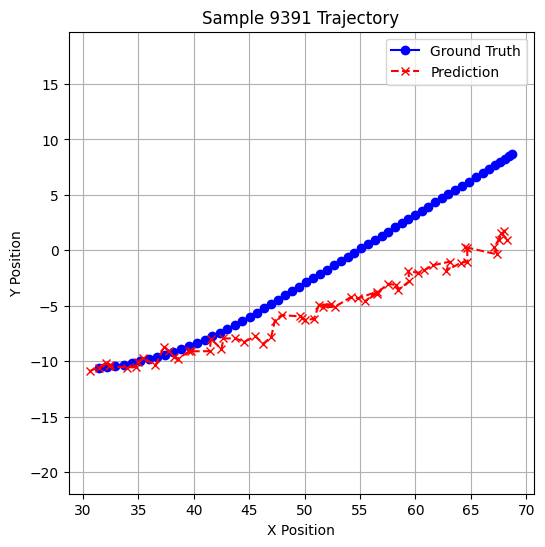

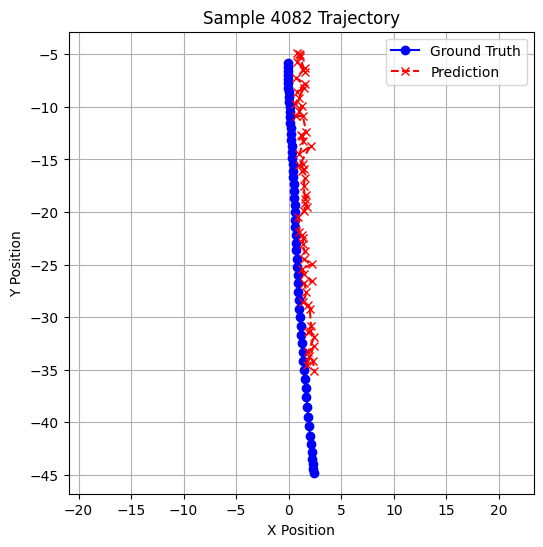

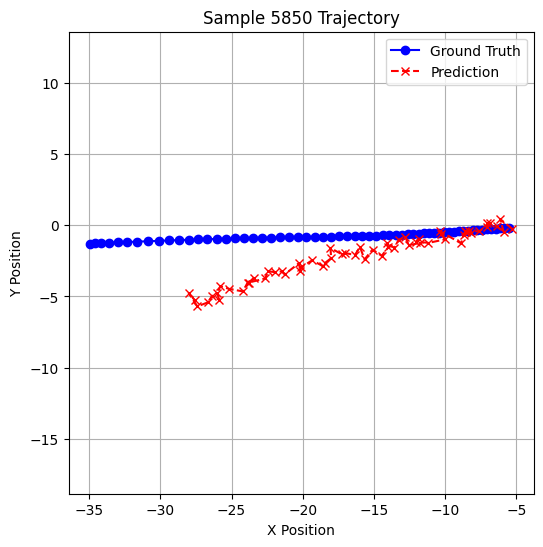

In [136]:
import numpy as np
import matplotlib.pyplot as plt

# extract specific features
train_sample = train_y[sample_indices]

# Assume:
assert pred_y.shape == train_sample.shape

for i in range(pred_y.shape[0]):
    x_pred = pred_y[i, :, 0]
    y_pred = pred_y[i, :, 1]
    x_gt = train_sample[i, :, 0]
    y_gt = train_sample[i, :, 1]
    
    plt.figure(figsize=(6, 6))
    plt.plot(x_gt, y_gt, label='Ground Truth', color='blue', marker='o')
    plt.plot(x_pred, y_pred, label='Prediction', color='red', linestyle='--', marker='x')
    
    plt.title(f"Sample {sample_indices[i]} Trajectory")
    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.show()


 # Now you can submit to the leaderboard!